In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import scipy
import pickle
from sklearn.metrics import pairwise_distances
from sklearn import preprocessing
import random
from collections import Counter
from tqdm.notebook import tqdm

%matplotlib inline

Read in the data from the unmodified mRNA experiment and sort by total reads.

In [2]:
df = pd.read_csv("../data/GSM3130435_egfp_unmod_1.csv")
df.sort_values('total_reads', inplace=True, ascending=False)
df.reset_index(inplace=True, drop=True)

Check the distribution of read counts

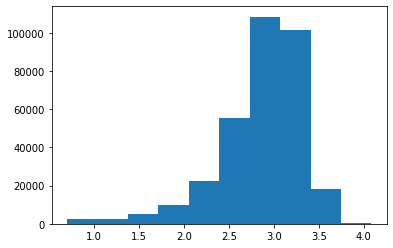

In [4]:
log_reads = np.log10(df['total_reads'])
plt.hist(log_reads)
plt.show()

The authors chose to only use the top 280,000 sequences. This corresponds to sequences with at least 267 reads.

In [5]:
df.loc[280_000,'total_reads']

267.0

Subset for top 280,000 sequences and identify sequences with uAUGs.

In [6]:
df_subset = df.iloc[:280000]

# Create column that identifies upstream AUGs
df_subset = df_subset.assign(uAUG=df_subset['utr'].str.contains("ATG"))

Check that all UTR sequences are 50 bp long

In [7]:
lengths = df_subset['utr'].map(len)
lengths.value_counts()

50    280000
Name: utr, dtype: int64

Check that no UTRs are repeated.

In [8]:
sum(df_subset.duplicated(subset='utr'))

0

Check distrubution of mean ribosome load.

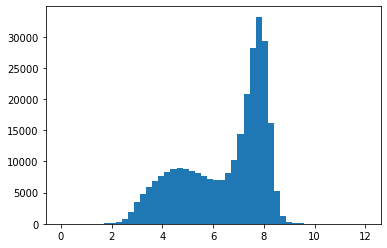

In [20]:
plt.hist(df_subset['rl'], bins=50)
plt.show()

Look at ribosome load distribution for uAUG and no uAUG separately

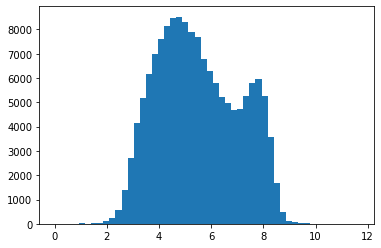

In [21]:
plt.hist(df_subset.loc[df_subset['uAUG'], 'rl'], bins=50)
plt.show()

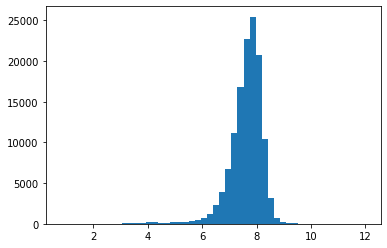

In [22]:
plt.hist(df_subset.loc[~df_subset['uAUG'], 'rl'], bins=50)
plt.show()

Check the nucleotide content distributions for the UTR sequences.

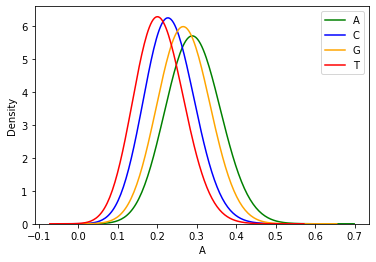

In [10]:
bases = ['A', 'C', 'G', 'T']
def char_count(seq, chars):
    return [seq.count(c)/len(seq) for c in chars]

bp_freqs = np.array([char_count(seq, bases) for seq in df_subset['utr']])
bp_freqs_df = pd.DataFrame.from_records(bp_freqs, columns=bases)

sns.kdeplot(data=bp_freqs_df, x="A", color='green', label="A", bw_adjust=5)
sns.kdeplot(data=bp_freqs_df, x="C", color='blue', label="C", bw_adjust=5)
sns.kdeplot(data=bp_freqs_df, x="G", color='orange', label="G", bw_adjust=5)
sns.kdeplot(data=bp_freqs_df, x="T", color='red', label="T", bw_adjust=5)

plt.legend() 
plt.show()

Check the average nucleotide content of all UTR sequences.

In [11]:
bp_freqs_df.sum()/280000

A    0.292706
C    0.232578
G    0.268041
T    0.206674
dtype: float64

Check correlation between GC content and mean ribosome load.

In [26]:
def GC_content(seq):
    return (seq.count('G') + seq.count('C')) / len(seq)

# print(GC_content("ACTCCG")) # 2/3
# print(GC_content("AATTA")) # 0
GC = [GC_content(seq) for seq in df_subset['utr']]


<AxesSubplot:ylabel='rl'>

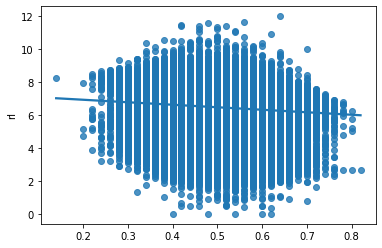

In [29]:
sns.regplot(x=GC, y=df_subset['rl'], ci=None)

Split into test and train. The authors chose the 20,000 sequences with highest number of reads as the test set.

In [12]:
# The training set has 260k UTRs and the test set has 20k UTRs.
e_test = df_subset.iloc[:20000]
e_train = df_subset.iloc[20000:]

Check that uAUGs are represented equally in the test and train sets.

In [13]:
print(f"Percent uAUG in data: {sum(df_subset['uAUG'])/df_subset.shape[0]}")
print(f"Percent uAUG in train: {sum(e_train['uAUG'])/e_train.shape[0]}")
print(f"Percent uAUG in test: {sum(e_test['uAUG'])/e_test.shape[0]}")

Percent uAUG in data: 0.5394964285714285
Percent uAUG in train: 0.5272038461538462
Percent uAUG in test: 0.6993


It looks like the test set that the authors used is enriched for sequences with uAUGs. Here's what we would expect:

In [14]:
random_seqs = ["".join(random.choices(['A', 'T', 'G', 'C'], k=50)) for i in range(100000)]
sum(['ATG' in seq for seq in random_seqs])/len(random_seqs)

0.54288

The authors included this plot in the supplement: ![](../images/reads_vs_performance.png)

The model seems to perform much worse on the sequences with no uAUG. Look at the proportion of uAUG-containing sequences in each of these bins:

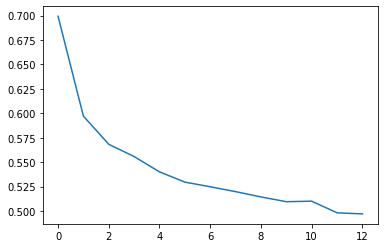

In [15]:
uAUG_freq = [sum(df_subset.loc[i:i + 20000,'uAUG'])/20000 for i in range(0, 260000, 20000)]
plt.plot(uAUG_freq)
plt.show()

Compare replicates. Keep top 120k UTRs with most reads (similar cutoff to rep 1)

In [16]:
df2 = pd.read_csv("../data/GSM3130436_egfp_unmod_2.csv")
df2.sort_values('total', inplace=True, ascending=False)
df2.reset_index(inplace=True, drop=True)
df_subset2 = df2.iloc[:120000]
df2.loc[120_000,'total']

267.0

Inner join the replicates on the UTR column to find sequences in both reps.

C:\Users\nmateyko\AppData\Local\Temp\ipykernel_7608\1999769913.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset2['utr'] = df_subset2['utr'].astype(str)


0


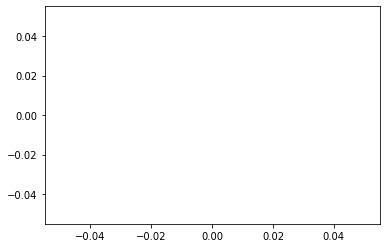

In [17]:
df_subset['utr'] = df_subset['utr'].astype(str)
df_subset2['utr'] = df_subset2['utr'].astype(str)
merged = pd.merge(df_subset, df_subset2, on='utr', suffixes=("_1", "_2"))
print(len(merged))
plt.scatter(merged['rl_1'], merged['rl_2'], alpha=0.1)
plt.show()

In [18]:
seqs = df_subset.loc[:100, 'utr']
sum(sum(df_subset2['utr'].str.contains(seq)) for seq in seqs)

101

Check to see if parts of the train UTR sequences are found in the test set due to PCR chimeras. If this is a major problem, the distribution of pairwise hamming distances between the train and test sets should differ from the expected binomial distribution.

In [19]:
# Split strings into arrays of chars
def split_seqs(seqs):  
    return np.array([np.fromiter(seq, (np.compat.unicode,1)) for seq in seqs])

e_test_split = split_seqs(e_test['utr'])
e_train_split = split_seqs(e_train['utr'])

# check that only A, C, G, T present in UTRs
uniques = np.unique(e_test_split)
print(uniques)
print(np.unique(e_train_split))

# Convert characters to ints so that sklearn pairwise_distances can be used,
# which is much faster than my own hamming distance implementation
test_encoded = np.searchsorted(uniques, e_test_split)
train_encoded = np.searchsorted(uniques, e_train_split)

# Calculate pairwise distances between train and test
dists = pairwise_distances(X=train_encoded[:5000], Y=test_encoded[:5000], metric='hamming')

['A' 'C' 'G' 'T']
['A' 'C' 'G' 'T']


`pairwise_distances` gives a proportion instead of the actual hamming distance, so multiply by 50 to get the hamming distance. 

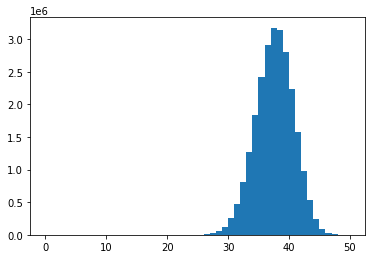

In [20]:
flat = dists.flatten()
flat = np.rint(flat * 50)
plt.hist(flat, bins=range(51))
plt.show()

Count the frequency of each hamming distance and convert to a pmf

In [21]:
counts = Counter(flat)
counts_list = counts.items()
freqs = np.zeros(51)
for count in counts_list:
    freqs[int(count[0])] = count[1]
total = sum(counts.values())
freqs = freqs/total

Compare observed pmf to the expected binomial pmf. The binomial assumes that all bases are equally likely, which isn't quite true (see above).

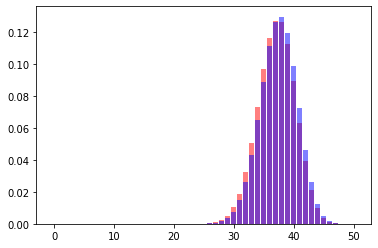

In [22]:
plt.bar(range(51), freqs, color='red', alpha=0.5)
plt.bar(range(51), scipy.stats.binom.pmf(range(51), 50, 0.75), color='blue', alpha=0.5)
plt.show()

Simulate what it would look like if test and train were exactly the same.

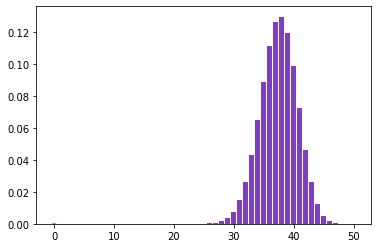

In [23]:
rand_sample = [random.choices(range(4), k=50) for i in range(5000)]
dists = pairwise_distances(X=rand_sample, Y=rand_sample, metric='hamming')
flat = dists.flatten()
flat = np.rint(flat * 50)
counts = Counter(flat)
counts_list = counts.items()
freqs = np.zeros(51)
for count in counts_list:
    freqs[int(count[0])] = count[1]
total = sum(counts.values())
freqs = freqs/total
plt.bar(range(51), freqs, color='red', alpha=0.5)
plt.bar(range(51), scipy.stats.binom.pmf(range(51), 50, 0.75), color='blue', alpha=0.5)
plt.show()

Probably not the best way to check for test/train violations!

Instead, manually inspect the test/train pairs with the lowest hamming distance to see if PCR chimeras seem to be an issue.

In [24]:
dists = pairwise_distances(X=train_encoded[:50000], Y=test_encoded[:10000], metric='hamming')

In [25]:
np.amin(dists)*50

1.0

In [26]:
train_ids, test_ids = np.where(dists * 50 == 1)
for i in zip(train_ids, test_ids):
    print("".join(e_train_split[i[0]]))
    print("".join(e_test_split[i[1]]))
    print("\n")

CCACATATCGTCGAGGACAACTCCTAAGTCAGACAGGATAACCTGGAATT
CAACATATCGTCGAGGACAACTCCTAAGTCAGACAGGATAACCTGGAATT




In [27]:
train_ids, test_ids = np.where(dists * 50 == 17)
for i in zip(train_ids, test_ids):
    print("".join(e_train_split[i[0]]))
    print("".join(e_test_split[i[1]]))
    print("\n")

AGGACAACGAGTGCAAAACAGAGTTGTAGAGGCTGGCAGAAGGATAAGAA
ACCACAAGTAGATCAAAACAGTGGTGTACAGACCCGCCGTGGGATAACTA


GGCACGAATTTAATTGGTCCGAATGCGGAAGCAGCTAGCGAAGAACTACC
GCGACGATTTCAATTGGTCGTTAAGGGCGAGCACATAGAGACGAATGACC




In [28]:
del dists

In [40]:
def max_run(seqs1, seqs2, min_len):
    rows = len(seqs1)
    cols = len(seqs2)
    seq_len = len(seqs1[0])
    a = (seqs1[:, None, :] == seqs2[None, :, :]).reshape(cols * rows, seq_len)
    m,n = a.shape
    A = np.zeros((m,n+2), dtype=bool)
    A[:m,1:-1] = a

    dA = np.diff(A)
    nz = np.nonzero(dA)
    start = (nz[0][::2], nz[1][::2])
    end = (nz[0][1::2], nz[1][1::2])

    run_lengths = end[1]-start[1]
    argmax_run = np.where(run_lengths >= min_len)
    row = start[0][argmax_run]
    return (list(seqs1[row // cols]), list(seqs2[row % cols]), list(run_lengths[argmax_run]))

def find_long_runs(train, test, split_size, min_len):
    runs_train = []
    runs_test = []
    lengths = []
    for i in tqdm(range(0, len(train), split_size)):
        for j in range(0, len(test), split_size):
            seqs1 = train[i:i + split_size]
            seqs2 = test[j:j + split_size]
            res = max_run(seqs1, seqs2, min_len)
            runs_train += res[0]
            runs_test += res[1]
            lengths += res[2]
            for seq1, seq2 in zip(res[0], res[1]):
                print(f"{''.join(seq1)}\n{''.join(seq2)}\n\n")
    return (runs_train, runs_test, lengths)

In [41]:
long_runs = find_long_runs(e_train_split, e_test_split, 4000, 15)


  0%|                                                                                                        | 0/65 [00:00<?, ?it/s]

CCCAATGCGCTGTGGGTGAAAACGCGGAACCGATTATTTCCTGTGTAGAC
CCCAATGCGCTGTGGTCCTTTAGAATGCACCGTCACAATAACTTGTAGGG





  2%|█▍                                                                                            | 1/65 [01:12<1:17:09, 72.33s/it]

ATGAGGGAGACATGACAAGCGGATTTTGGAGTCTAGAAGTTTCAAACAGC
CCACAACAGACATGACAAGCGGCTAATCCTTAGCGCTACTGGCCCACGGT





  3%|██▉                                                                                           | 2/65 [02:20<1:13:13, 69.74s/it]

CCCCCGCGTCGGATCGGGATAAAACCAAATCCCCGCCGGGCCCGACAGAA
CAATCGCGTCGGATCGGGAAAGTCACCTAGGACCGTCCACGTCAATCGAA


TCGCGGACAGTGCAGCATGATGCAAGTATCAATCACAAACGGTCGCGGAC
ACTGAAGCGGCAGCGAGGGATGCAAGTATCAATACGACGGGAGAAATCAA


TCGATGTAAGCAATGGGACACATACTTCGAAGCCACAAACGATCTATCCC
GGACATGGGTATACGTCGTGGTGTCTTCGAAGCCACAAAATGACATCATG


GTTAGATGCATACGAATACGCAACACGGAAGTGGCGAAAAATCCGGCGTC
AAATTAATTCGGAGAAAGGCGAAAGATGAAGAGGCGAAAAATCCGGCCAA


CATGTTTGAGTCAAGCCGAGTCGAAACTGCTGTTCCGCCTAAACGCTATA
AATGTTTGAGTCAAGCCGAGTCGAAACTGCTGTTCCGCCTAAACGCTATA





  5%|████▎                                                                                         | 3/65 [03:29<1:11:38, 69.33s/it]

CCTCCTTGGTCGGAGAGCGCCCGTCTGCTTCGGAAAACGTGTCTCCAGTG
CCAACCGTCTCGTAGTGCCCACGTCTGCTTCGGAAACACTTTCAGTCCGC


CCCCTCGGATTGACATACTCGTATTCACGAAGGGCGCTAGCGTAATGAAC
ATTATCGGATTGACATACTAAACAAACGTATGTTAAAACCGACGTGTGCC





  6%|█████▊                                                                                        | 4/65 [04:34<1:08:59, 67.86s/it]

CCCAGCCTGGTAGCTCAAGTGTCCTGGCGGTATAAAACCATAACGAGAGT
CCCAGCCTGGTAGCTGCTATAGCACTTGACGCCTTACGCGGACCAAAACT


CGAACGGACCTACCCTCGGGGTCAATAGGAACACGAAGGCTTACAAAGGA
CCGGTTACTGGAATGGACACAAGATCAAGGAAAAAAAGGCTTACAAAGGA


GAAAACGGACTAGCTGGATTACAACGCATGCTAGAATGTGATTGTCAACA
CAAACACTTACGATCATTAAGCTAAGAATGCTAGAATGTGATCCGGCTAA


CGGAAATACCCGTATTGCTTCGCTAGTGCCGGTACTGGATCGTTTCACCA
CTAAGCGACCCGTATTGCTTCGAACGTATTATTTAACCTGCCCGGCACAG


GATACTTAGAACATCTGAAGTCGGCTCTAACGTGACGCACCCGGCTAGGT
CAACATGGACGCGCCAAGCAACCGCTCTAACGTGACGCAAGAGCGTGAAT





  8%|███████▏                                                                                      | 5/65 [05:44<1:08:33, 68.56s/it]

GACAACAACGCTGCATAACATATTTTAGAGGAAATGGGAACAGTTACATT
ACGTGCTTGATAGTAAGCTAGTCCAGCGAGGAAATGGGAACACCAAACGA


TCTAACCGTGAAGACAGCCCTGTAGGCGGGTTACGAGGAAGAGTCAAGCG
CCCTATTTGGCAAGCAACCGCGAGCAAGCTTGGCGAGGAAGAGTCAAGTT


CAACACAGATAACAACTAATATTTACGGTAGTAAAAGCGGAATGCACCAA
CCACGGAATGACTCTCCAGTGAGAGCGGTAGTAAAAGCGGCCGCGACAGT





  9%|████████▋                                                                                     | 6/65 [06:51<1:07:03, 68.19s/it]

TAAAAGGCTGATTGAGTAACGTGAAACGGTTACATTACGTCTAGTAACTA
AGACAGGCTGATTGAGTAAGTCCATAGTTCCAGCCTGCAGTAGTAAGAAG


AAGTTAGGCGGGATAACAAATATTTGACGAGAAGAATAGTGAAATTTAGC
CCATTTGCGGACCTAACAAATATTTGACAGTGCACAGAGCACTATAGGAA


CCGTCTAGAGTTATTCGTTGAGTCACGCCAACTGAGGATCGTTAAGGATA
TAACAAACCCTTTGAGGAGTCTCCTAAGGGAACGAGGATCGTTAAGGAAA


CCCTGTATGATCGAGTGGCAAGACTGCGGCGAGATATGGGGAACTTACAG
GGAAAATGGCACATAAACCACCGTTGCGGCGAGATATGGGAATCCCGTGA


CCGGAGGTGAAATCATTAGTCATGGCCGGATGATTCTACGCAACGCGCGA
CAAGAGGTGAAATCATTATCCAGTAAGTATGTGTGCAAACACGTTGTACG


AGTCAACGCATCAAGTGGAAGGGACTCAGCGAGGGTATCGGAAATGTAGG
GACCCGGCCGCTCGGAAATTCTGCCCGTACATTGGTATCGGAAATGTACC





 11%|██████████                                                                                    | 7/65 [07:58<1:05:30, 67.76s/it]

GTACGGACGACGGGAGGGGGTCGTGCGCCGCTGTCCGACCTACGACCCGA
CTACGGACGACGGGAGGATACCCTATCGTGCATGTGCTCGGCGAATAAAA


ACGAAGCGAGGCTCAGAATAATTGGATAAAGGTTAGACAGGCACCGGGAA
CTCATGCATTCGAATAGAGTGCTGGATAAAGGTTAGAGTGAGGTGCTACC


GCGAGTCTCGGCTAAACAGTTCTCCCGTCCGGTGGATGGAGTTAAGAGAA
CGAACTCTCGGCTAAACAGTCAATAATAATGCCAAAGCACTGTCCCCTGG


GCGAGTCTCGGCTAAACAGTTCTCCCGTCCGGTGGATGGAGTTAAGAGAA
CCGAGTCTCGGCTAAAGCTGCAAGAATAGGGCGCAGACATAAAAAGGATG


CCGACCTGCGGAGGCGTCGAAATGAAATCCGTAAACGGCGTAACGGGCTT
CCGGCCTGCGGAGGCGTCGCAGGGGAGTGGTCCTGGTCCAGCTAATTGAA





 12%|███████████▌                                                                                  | 8/65 [09:06<1:04:19, 67.71s/it]

GAATGCGGTGGGTAAAAACGCTGGCGCCCCGAGAACAACTGTCAAGGAAA
ACGGCCCCAAGGTAAAAACGCTGGCCGGATGAAACCAGCAGTGAATGACT


AAAATTCAATACACGTCTGGGCTTTAGCCCAGGTCGACGGGCTTCTATCG
TTGAAGGATGCACCATCCTGGCTTTAGCCCAGGTTTCCAACACTTAGATA


CCGTAGCGGCGCGAACGACCCACCGAAGTGCTCTTTGAACTGCGCGAATA
AACGATGAAGTCCGTTCCCGGAGAGCTCTTCTCTTTGAACTGCGCACAAA


CCGAAAGGAAGGTAAAGTAATGGACCGGGTAGGATTAGCATCGAGAATTA
CCGAAAGGAAGGTAACGTGAAACTAACCCCGGCTGCCATGACTTATAGTG





 14%|█████████████                                                                                 | 9/65 [10:12<1:02:46, 67.25s/it]

CCCGACGAATTGCGCATCACATTACGAGGGGCTACGCACGAATATACCCG
TACGATGATGCACCGCAGCCCGTACGAGGGGCTACGCTTGGGAAGGCGTG


TCAACATAATAGACTTCCGACACTAACGTGGGTGTCGATTATAGCCAAAG
GAATGCAACGCCAATCTACCACGTAACGTGGGTGTCGAAGCTTGGTACTG





 15%|██████████████▎                                                                              | 10/65 [11:20<1:01:49, 67.45s/it]

CCACATATCGTCGAGGACAACTCCTAAGTCAGACAGGATAACCTGGAATT
CAACATATCGTCGAGGACAACTCCTAAGTCAGACAGGATAACCTGGAATT


CCTGACTGAGTGGTTCCGGCTCAAGATTATGATTCATCAGGGTACGATAA
CCATGAGGCCTGGCGCCGGCTCAAGATTATGCGGGTTATGAATGTGTACT


CCCCTATACAAGGGACTCAGACCCGGAAGAGAGGTAAAGAAAACATACTT
TCTCCCCTAGACAAGGGCGACTATGGCGCGAAGGTAAAGAAAACATACAC


CCACACGTGCGAAAGGCCGACGGCGTAGTGAGGCTCAAATACGGTGATCC
CCACACGTGCGAAAGATGCAGCGAGGTTTCAGCATAGAAGGTCTTTAGAA





 18%|█████████████████▏                                                                           | 12/65 [13:38<1:00:33, 68.55s/it]

ATCTTAGTAAACTGATACTGTTAAAGGAGAATGAACATGGGCAAGTCTAA
TAACCAATCCGCCACCCTAAGACCAGGCCAATGAACATGGGCAATTCTTC


CTCACACTGCAATGCTAAGACAGAAAGAAACAGAACGTCGACATATTCCA
GCCGGGCTTTGGTGCTAAGACAGAAAGCAAGGCAACTCCTTGGTGAGGAA


AGTAGGACAACCTAAATAAGAAAGTAATGCATTGTATGCTACCCGACACA
AGTAGGACAACCTAACGAGAGGCCTGACTTCATGTAGTTCACTCTACAGT





 20%|███████████████████                                                                            | 13/65 [14:44<58:35, 67.60s/it]

GTATCTGTGGACGGTATACAGTATTGGCAAAGGTAAAGTCTATCAGGGAG
GCCAGAAAGCAGTGCAAAAGGCCGGACCAAAGGTAAAGTCTAGGCGAGTA


GTGCATCTATTCAAAGCAAGCCAAGCCAAATATAAATGAGAAAGTTTCAA
GTGCATCTATTCAAAGGAAATCCCATGGAGGCAAAGTTGAAGGGTGCGCG





 22%|████████████████████▍                                                                          | 14/65 [15:49<56:52, 66.91s/it]

AGTAAGTAGGCACTCACGCAACCATACGAGAGGTCATATCACCGGTCAGG
CCAGCGTAGGCACTCACGCATGAAGCAAAGACATCGTTTTAGTCTTCGTC


GTAGGCAACTCAAGACAAACCCAAGGGATTCCCGACCAAAAAGTAGGGTT
GTTTCCCCTGCTAACCAGGGTCCTCTGATTCCCGACCAAAAGCTCACAAG


GAATGGATTGTGCGGTGTCATTTCAACAGGAGATGAGCTGTCTGGAACTA
TATTGGCTTAAGAAGGCTCATTTCAACAGGAGTCAAGACCTCTTCCAACA


CCGTCAATACCTGTGGGCGAAAACTCTAAGGCAAACAGATGAACGGTAAC
AGGCAATAGCTATAGAGGCATGGAACCCAGGCAAACAGATGAACATAGGA





 23%|█████████████████████▉                                                                         | 15/65 [16:54<55:14, 66.30s/it]

CCTGCGCGATGGCAGTGAGCTCGAGACTGACAAAATACCAGAAGTGGAGG
AGAACGAAGAGAAAAGCGCACGAATAAGATGCAAATACCAGAAGTGGGTT


CCACACGGGTCCGCGATCGGAACCTCGGGTCACCAGATGCAATATGAGAG
GCACACGGGTCCGCGAAAATGCTTTTCGGTCCCCTGCGTAGATTGTAACA





 25%|███████████████████████▍                                                                       | 16/65 [17:58<53:41, 65.75s/it]

CCTGGGACCCGTTAATATTCAATTGCATACTCATGTACACCGATGGAAAT
CAGATGCGAGAACGTCCGAAATGGCCACCCTCATGTACACCGATCTAAGG


AGTTTACGTACCTGGTTTAAAGGAAGCTTTTGAACTAAAGTGCATCCATA
GGTAAGAATACCTGGTTTAAAGGCGTAGCGAGATGGCTCCTATCGACTCT





 26%|████████████████████████▊                                                                      | 17/65 [19:04<52:29, 65.61s/it]

AATTGTCGCCCTAAAAAGGACTAAATCCACGAAAAAAAAGAGTCATGTAC
CCTAGAGATGCCACACTCAAAGCCTGGGAGTAAAAAAAAGAGTCATGCGC


GCCGGGCAAGTACACCTAGTGCGAGTCACAACAGTCGCAAAAAAATGCGG
CACCATGTATCTTAGGTGTGGCGAGTCACAACAGTGTCGGCTTCTGTACA





 29%|███████████████████████████▊                                                                   | 19/65 [21:13<50:03, 65.29s/it]

CCCGAAGGAAGTGATGAGTATCAGATTAAGCGCACCGGTAAGTCAAACGG
GTGGTAGGAAGTGATGAGTAATACGGCCGAAAGATGCGAATGGTTCTCTA


CGATAGAGTTGAAGTGGAACGGTGCCATCTTGGAACAGAACGCAAGAAAC
ACAAGCGAGTGGTAGCTCTCGCAGGTTTGCTGGAACAGAACGCAAAGCAA


TACAGACCCAATGCAAAAACAGGGCTAAGCACGTGGAACGCGTGGGGAAT
CACATGTTACAGAGAAGAGCCAACCGGGCGACGTGGAACGCGTGGGAGAT





 32%|██████████████████████████████▋                                                                | 21/65 [23:24<47:58, 65.42s/it]

ACGCGATGGCTGAAGACCGCGACGGCAGACCGGAAGGACACGCGTCCACT
GATAAAGAGCATGGTAAAACAGAGGCAGACCGGAAGGATTGAGGCGCCGG


CACACAGTAAGGCGATGCCGACCACCCGTGAAGATACCATCTAAGGACTG
CCGCACCAGTTCTGATGCCGACCACCCGACGCGCCAAAACGTGCTCCTCG


CCAGAGCAAGTATTGATGACAGGTGGAATGAACGTAAAAGTAGCCGATCG
TTTGCCACCCGGTCTAAGACAGGTGGAATGAAGGCATCCGACGGCGCCAA





 34%|████████████████████████████████▏                                                              | 22/65 [24:27<46:31, 64.92s/it]

CCGTTGGAAGCTTCATTTTGACTATGGATAAGAGGGCCAGACAAAAGTTC
CGCAATGCATCGGGTGCCCTCAGTAGGCCTATGGGGCCAGACAAAAGTGG


CCGACGGCGAAAAGCCGTCAATACCCAAGGTCAATCGTTTGACACACTAC
GTTGGAGAGGGGAGAGTTAACACCGCAAGGTCAATCGTTTAAAGCCTACG


GCGGACGCCCAAAGGTAGCGCGCGAGGGGAATGGCAAAAGGTTACATAAC
CGCAACATCCCACCCTCATGTTCGTGGGGAATGGCAAAAGAGTGTTGCCT


CGCATGGACCTGAAGGCACTCCGCAGAGTGTACATAGTAAGTCGGCGTAC
CCGCAGCGGAAAAAGGCACTCCGCAGAGTTAGTTTACAAAGAAATCATCA


AACATGGCAGTGATGGCCCGCAAATCATTTTGTCACCCGAGTAAGGTGCT
CACATGGCAGTGATGGCCCGCAAATCATTTTGTCACCCGAGTAAGGTGCT


CCGTGCAGTAAAGGCGGAACCGTTTCGTAACCCACTAGGCCGCCAACGAG
ACGCCGGTGAGTTATAGCGGCGTTTCGTAACCCACTCTGCGAGTGTAACT


TATTAAAAGGCAACTGCATCGCGGTCCCTCGGTCACGACGCAAAGAGTCA
CTCTGACAGTATGAAGGAAGGCGGTCCCTCGGTCATGACGACCTTGTTTG


CTATATAACACACGGTGGGAACCACGTGGCATCACACTACTCGGTCCAAG
CGAAATGTTGGTAAGTGGGAACCACGTGGTAGTCCGGCCGAACCAGAGCG


AGCATAAGGACACGTAATTAACCAAGATGGTGGAGAGTTGAAGAACTGAC
CGCATAAGGACACGTAATGGGCCAACTGCCCTTATCGGACTCAAATTTTG





 35%|█████████████████████████████████▌                                                             | 23/65 [25:35<46:00, 65.72s/it]

CTTCAACATATGAAATAAAAATATGAATGGAAGAGGGTTCACTAAGATAT
AACTATTCGATGCACGGTAAATATGAATGGAAGGTCGTGATGAAGGCTCG


GTGAGTATGCATCGTACAGAAATTTGGACCGAGGACCGCGACAGTATGAT
GCCACCAAACCGGATACAGAAATTTGGACGATGGTCCTAGGTACGGAACA





 37%|███████████████████████████████████                                                            | 24/65 [26:38<44:23, 64.97s/it]

ACTGCTCTTAAGGGTGATGGGAACATATTTCATGTTAAAAAGATCTACGT
TTGTAAAACAAGGGTGATGGGAACGCATTTGTGGCGGGAGCAGCGGCCCC


CCAAAGGATAGATCGTGTGATTCCGACCCAGGAAATGGGCATTGCACCTT
GGAGGTGTAGGCATATTCCTTCCAGACCCAGGAAATGGGGACATCAGACC





 38%|████████████████████████████████████▌                                                          | 25/65 [27:44<43:34, 65.35s/it]

CCGTTTCAACCGGGCGACGTTTCAGAGAGGGCATAATGACGTTTAACAAA
TTAAAGGGACACAGCTATTAGCCCGGTCACGCATAATGACGTTTACAAAA


CTCCGTAGTGCGTTAGAGTACCAGACACCACAAAGGTTGGTCATGGAACT
CGAAAAAGATATGGCATCCATGAGACACCACAAAGGTGCTATATTGTGGG





 40%|██████████████████████████████████████                                                         | 26/65 [28:49<42:22, 65.19s/it]

GTATGGTAGTTCATCGACAGCCTCAAGGAATGTCGCGAATTAGAGTCACT
CCACAAGTTCATTACAGGACTTTTGGATTCAAGCGCGAATTAGAGTCAAA





 42%|███████████████████████████████████████▍                                                       | 27/65 [29:58<41:56, 66.24s/it]

GTAGGCACAATATCCCAGGTCCCTTAGCTACCAATGGTCGAGAGCGGCCA
CTCGACAAAACGAGAAGCAGATTTGAGCTACCAATGGTCGACAAGTAATA


CTTTGCAGGACCTCGGTAATCGCACGCCCAGGCACCCATGTGCAGAGAAG
ATTTGCAGGACCTCGGCCGGTCATCATGAACTGCAAGAGTTCAAGCGGAG


TCCGAATATGTTACTGCATGAGAAAAACGGAGACAATGCATATGACGGTA
CAGGTGTCAACCGCAAATCGCAGGGAACAATGAAAATGCATATGACGGTC





 43%|████████████████████████████████████████▉                                                      | 28/65 [31:05<41:00, 66.50s/it]

CAACGATTCGGTGGCATACACGCAAGGGTGGGGGAAGAGCCATTGCCAAA
AATACGTCCTCGCGCATACACGCAAGGGCAAGAGACACAGGAGGTGTGTA





 45%|██████████████████████████████████████████▍                                                    | 29/65 [32:08<39:19, 65.54s/it]

CAAACACCCAACTCAATGAAGACAGCTCCAAAGCCAGCTAGCTAGCATAC
GTGCAACGCAACTCAATGAAGACAGGGACATGAATCATCGCGGAGAGTTG


GAGACGAGCACCGCCATCGGCGATAACCTTTGACTACACGTGAGCACGGT
CCACAAAAGGTGAGCGGATTCTCTAATGACGAACTACACGTGAGCACAAC


CCTAGATCTTGAAGCGCACGCCCACCGTGACACACTGCCGCCGGTAGCTG
TATACGGAACATCAAACGGAATCGATGCGGGCCACTGCCGCCGGTAGACC





 46%|███████████████████████████████████████████▊                                                   | 30/65 [33:14<38:18, 65.68s/it]

GCGGGACGGAGGATGCGAGTAAGAAAGCTGTCTCATTGAAATACGAAAAC
TGGTGAACTGCGATGCGAGTAAGAAAGCGGGATTAGAACGACTTGTAAGG


GGTACTATCTGGAGGCCGTCTCACCTCGGTCGGAGTTAACGCTATTGTTC
AGCTGGGAGCTCGCCCTAAAGCGTTACTCTGGGAGTTAACGCTATTGGAG


CGTCTCGGAAGCGCGAGCGCGAATAAGCGAGAGGACAGTAGGTGAAAATT
AGGACGAATTTCACCCCGGCGAATAAGCGAGAGAGGCCTGAACGAATCGG


AAGCCAACGAGGGTGTTTATAACTACGACAAGGGAGATGTGACAATAATC
CCACACCCGCGGACAGCATATAACCCGAACAGGGAGATGTGACAAAGATA





 48%|█████████████████████████████████████████████▎                                                 | 31/65 [34:17<36:40, 64.73s/it]

CATAGCGTCACTGGGTGTCAACGCATGAGATGTAAACTACAATTATGATA
CCTAGCGTCACTGGGTGTCAACGCATGAGATGTAAACTACAATTATGATA


CGTATGGAAGGCAATAATTGTAGACGCAGGGCATGAGAGGCTTGATATGC
CTCAAAGTAGGATCCAAGTCCAGACGCAGGGCATGAGAATGGAAACTGCA


CATACCCATCAGCACACCGGATATGTGCAAGAAGAGGATAGACGACCCAG
GATACCCATCAGCACACCGGATATGTGCAAGAAGAGGATAGACGACCCAG





 49%|██████████████████████████████████████████████▊                                                | 32/65 [35:24<35:56, 65.34s/it]

CCACAATGACCTGCGAGCCTGCGGGTGGAACGCAGGACAGTTCATTAGTT
CAACAATGACCTGCGAGCCTGCGGGTGGAACGCAGGACAGTTCATTAGTT


CCCCTGTAACACTTGCAATAAGTCCACCGCGATGGCGGAAGCATTCTTCA
CACCTGTAACACTTGCAATAAGTCCACCGCGATGGCGGAAGCATTCTTCA


AGTGATACATTCAATGGGTGCGACCGATGGTAGTTTGTTAGAATCCAGCA
CGTGATACATTCAATGGGTGCGACCGATGGTAGTTTGTTAGAATCCAGCA


CCGGCTTTGGCCGAGACAAATGGCTCAAAAGGCGACTCGTGACTTCACTC
GTGAGCCCTGTCGAGACAAATGGCTCATCGGCTGGCAAACAAACGTAATT


AAGAGGTCGAGCGGGGTCAAGCAGTAATTCGAATACAGGAATCTGACACT
CGAAATCATTTAACATATAAGCAGTAATTCGAACCCTCCACTCGGACGAA





 52%|█████████████████████████████████████████████████▋                                             | 34/65 [37:34<33:49, 65.45s/it]

GTCGACTAGTATATATTGTGACAGAGACAGTGAATAATTAACGGGCGTGA
TCTTACAATGCGAAGGTGTGACAGAGACAGTGCACTCAACACCGACTCAG


CTGAATATCGTAAATGCAAGGCAACGCGCGAGCTAGTAGTAAGAAAGCAT
CGATAGTAGGCGTCGAGCCTGAAACGCGCGAGCTAGTGCAGAACTGTGAA





 54%|███████████████████████████████████████████████████▏                                           | 35/65 [38:38<32:32, 65.09s/it]

AATAAATTCTGATTAAGATGCTGGCCACAAAGATACAATGTCTGAAACTC
CCCACGAGCAGGTTCTTTAGACATTCACAAAGATACAATGTTCAAATGAA


CGAGCGTGCCACCGCTCGTTTCGGAACAAGAGCTAACCAGCCAAAGGAAT
CCCCAGAGATGGGATAGACTATGGAACAAGAGCTAACCCGGAGCCGGAAA


CCGGCAAACTGAGGGGAAAAGTTAACTAGCATAGGCTAATGGAGGGTCAA
AACATGCTTACCAACGGAAAGTTAACTAGCATTTCATATCTGAAGAAGTA


CCTGGAACAAGGTGCGGGAAACACGCAGGACCAATTACAACTTCTGTCCG
TTCGACCAAGCTGACCAGTAGAACGCAGGACCAATTAGAGGAGTTCCACA


CCGAATACGTAAGGAGAAGCCAACGTTACACTCGACAGCTTACGCAACTT
CATTCACTCATGATAGATGCCAACGTTACACTCGTAAGGAGGCACTTACC





 55%|████████████████████████████████████████████████████▌                                          | 36/65 [39:43<31:29, 65.16s/it]

CGAATCTCTACACAAGGAGTCAGGTACATGAGAGAGATAGCGCGACGTGC
CCACAGATGACGCAAGGAGTCAGGTACATACCGGAACACTCAGTCCACAA





 57%|██████████████████████████████████████████████████████                                         | 37/65 [40:47<30:14, 64.82s/it]

ATCGTTGTATAAAGGCAATACTAAGCAAAAGCTCGTGGGGATTAGAAGGA
CACATGGATAACAATGAGGCTGTCTTGACAGCTCGTGGGGATTATTACGG


CCCATCTCCCCAGATAGCTACGGCCCTAGCTCATGCACGGCAGATATAGA
GCCATCTCCCCAGATAGCTACGGCCCTAGCTCATGCACGGCAGATATAGA





 58%|███████████████████████████████████████████████████████▌                                       | 38/65 [41:52<29:11, 64.87s/it]

CCGCGTAAAACCGGATTGACGACCGCCCCGGATAGCTCCGCATCAAAATA
TGCCACTACCAACGACCTGGACAAGCCCCGGATAGCTCCCATTCTAGAAT


CAAATGTAAGCATAGAGTAGAACAGGCTGCAGACTAAAGCAAACAAACTA
CGAGTAGCGAGTAGTTGCATTTGCATGTGCAGACTAAAGCAAATGGTGTT





 60%|█████████████████████████████████████████████████████████                                      | 39/65 [42:58<28:09, 64.99s/it]

TTATAACCAAGCAAGTAACACCATCACAACGCCTAACCAGATGGCAAGGA
GGCTTACCAAGCAAGTAACACCCATCGTTTGCCACGGCGACATCTCAGTC


ATTCTCATGTAAGGCTTTAGTAATAACAACATAGTGGGAACGCGAGTTGC
CTGACCGTTATTGGCTTTAGTAATAACGCGTCACAGGCATAGAGCGGAGA


AAACCTTGAACTAATCGAACTAATCCAGCGCCACCAATCATAGTTGACTG
CTCGCCGAACCGCATGGAACTAATCCAGCGCTCGCCTGGAACTAAAGATG





 62%|██████████████████████████████████████████████████████████▍                                    | 40/65 [44:02<27:03, 64.93s/it]

TTTCGAGGCGCGGAACGAATACGCCGGGGTCTGAAGAGCTCTCATTTACG
GCAGCGTAGGCGGAACGAATACGCAGTATTACATCACAACGTAGTTGCGC


GGTGAATGAGTCAACAGACGGGGCTCCATTCCAAACTGGTATGATAGCAA
GGGGCGATTGCTCAGCATGCCCGATGCATTCCAAACTGGTAATCTCCAGT





 63%|███████████████████████████████████████████████████████████▉                                   | 41/65 [45:08<26:05, 65.23s/it]

TTAGTGTCTCCAAGGACAAAGTGAACTCTTCCAGAGTAGAATTGCTTAAG
AGTGTGTCTCCAAGGACAATCAAACTACGTGCCGTTTGTCCGTCTATGCT





 65%|█████████████████████████████████████████████████████████████▍                                 | 42/65 [46:11<24:45, 64.58s/it]

CCGGGCATGGCCAAAGGAAAGTAGCTGGTTCTTTACCTCAGAACCAGGGG
AACGCGATGGCCAAAGGAAAGCATATTGGAAAAACGAAAGCGCGAATAGG


CCGGGGACGCGGGTCATACTGGAACACACAGTGGTACCTAACGGAAGATC
TGTCGAGAAGTAATATGCATACGTCACACAGTGGTACCTACCGGCTGTAG


CGAAGGCACGACAACCGAGCGTAATAGAGTTTGCTTCTATCAAGGCCAAA
CGGCCATAGAACAACCGAGCGTAATATGGAGAGAAAGAACTATGTTCAGG


CAAGGTTGAAACGATGTCAAGTTGCATATCGTTAAGGGGCTTCATGATAC
AAGCGCCTCTAGCATGTCAAGTTGCATACGCCCACGGTAGTCAGAGGACA


CCGGCCAACGTCGTGAGAAAGATGATCAAAGGACTCTGGCAGCCGCCGGT
AGTGTAATGGTCGTGAGAAAGATGGAACAGAGAACGCCATAACATGCCGG


GTATCAAAGTAGGTCCAGTGACGGATTCGTTACACGCTCATGGAAGATTG
GCGTAGTAAGGATGCGGTATAGACCAGCTGTATGCGCTCATGGAAGATTT


CCTAAGTAGGCCGGTGCTGGAACGGCGATGCCTGGCTGCAAAAGATGTCC
GCTAAGTAGGCCGGTGCTGGAACGGCGATGCCTGGCTGCAAAAGATGTCC





 66%|██████████████████████████████████████████████████████████████▊                                | 43/65 [47:18<23:51, 65.06s/it]

CTCCACCCGCTCATAAGAGTCGGGCCGCCTTGACGCCAAGAGTGATAAAA
ATCCACCCGCTCATAAGAGTCGGGCCGCCTTGACGCCAAGAGTGATAAAA


GTAATGAGATGGTGTAGACGCCACAGATTGATTCCGTCGGTCAACTACTC
CCTCATAGATGGTGTAGACGCAATGCACGGTGTCGACGATTACGACATAA


CTACTTAGGGGTCAGGGATCACAATCATGTACTCAGGCAGTTCATATTCA
GTCGAATAGGGTCAGGGATCACATCCCAATGACGGTAGGAGAACTCGCGA





 68%|████████████████████████████████████████████████████████████████▎                              | 44/65 [48:20<22:29, 64.24s/it]

CCGGCCCCCACGAACTCACTTCTGCTCAAAACGAAGCTGGAACCTAACTA
CCGGCCCCCACGAACTGGGTTTAAAGCGTGCGCTCCCCCACCGCTTTGAC


CTCCCGGCAAGTGCTAGAATGGAATCCGGTAGCGCGGTTCTGGTCTCTGT
TCGCGAAATGAGCGTACCCTTCAGTTGTGCAGAGCGGTTCTGGTCTCTTA


GGGACGCGCACCAAACGGGCCCTATCACTTCCGGTACGGAACATGTAAAC
CGGACGCGCACCAAACGGGCCCTATCACTTCCGGTACGGAACATGTAAAC


CCTATGAGAAGGTTAAAAGGCACTACGCGTTGACAACAAATTATAGAGAA
TCTCAAAGAAGGTTAAAAGGCGGACATTCTAACTGCTGAAGCTATGTGCC





 69%|█████████████████████████████████████████████████████████████████▊                             | 45/65 [49:27<21:39, 64.96s/it]

AGCAGAGGACATAATCTAACTAACCACATGGAAAATTAGAAGTCTCAGTA
AAATGCAATGAACACACTAGCAACCACATGGAAAATCGTTCGTTCCGGCA





 71%|███████████████████████████████████████████████████████████████████▏                           | 46/65 [50:29<20:20, 64.23s/it]

GCGGGATACGGTAAAGGGCGCGAAAGAGTTTAACGAGCACGCGAAGATGT
TTTTTGTGGAGGATGGCGAACTACTGACATGAACGAGCACGCGAAGGACC


CACATGAAGGGGTCCTCGTTATGAGTCTCAAGTACGGTTGAAAGACATAG
CATAAGTATGTGTGAAAGGCTAGTTGACCCAAAACGGTTGAAAGACATCT


CCTCGCTCCCTACCAGTCTCTTTCAACATTCATGCGGGAGTACTAAATTT
CGCAGCCGCCCAAGCAGAACTCATGAGGTTCATGCGGGAGTACCATCCAT


CAGTTTTCTTTTGAATAAACGAATTATATGATGGAGACAGAAATGTCAGG
CCGTTTTCTTTTGAATAAACGAATTATATGATGGAGACAGAAATGTCAGG





 72%|████████████████████████████████████████████████████████████████████▋                          | 47/65 [51:36<19:32, 65.14s/it]

GCGGAGAACGAGGATAGCTCGATCCGGGTGACACAAGGACTAAGGCACGT
CCGGAGAACGAGGATAAGTGCGACGGCCGCGTGAACACGACGGGGTATCC


AGGACATGTACGGAAGGCACACTCGAGACGCAACCCAACATGTACGTGAC
CGGACATGTACGGAAGGCACACTCGAGACGCAACCCAACATGTACGTGAC


CCGGGTTCGGATAAGTGGCTTCGTGCCTACAAAGGTAGGCCCGAATGGGG
CGGCAACCAAGATCGTGGCTTCGTGCCTACCCCAAGAAGAGCGGCTATGG


ACCTAATAGGCCTCAAGACCGCTGACTGAGCCGCAAGTGTCTTAGAGAAT
CTAACAGTAAGCGGCGTATACCTGACTGAGCCGCAAAGTTGCTAAAAAAT





 74%|██████████████████████████████████████████████████████████████████████▏                        | 48/65 [52:42<18:28, 65.21s/it]

GAGAGAGCGCAACCTTCATACGAGCAATCTGCGCTAATGGTAGGGGGCGA
CCATAAAATCTTGTTAAGTACGAGCAATCTGCGACCTAGCATACAGGCCC


GAATGTAAAATTACGCCCAATGATACAGACAGGGACCAGCAAAACCCGCA
CAATGTAAAATTACGCCCAATGATACAGACAGGGACCAGCAAAACCCGCA


CAGAAGGATCACATCAATCATCGTAGGATTTTGGGATACTTTGACTCGAA
CAGAAGGATCACATCCTACCCGATGAGCAGGCTCAGACTTGCGTCCTGGT


ACATGAAGCGTAATGCCGTCCCGGACCTCAGTACTGACAGGGGTCACTTA
CCATGAAGCGTAATGCCGTCCCGGACCTCAGTACTGACAGGGGTCACTTA





 75%|███████████████████████████████████████████████████████████████████████▌                       | 49/65 [53:47<17:24, 65.29s/it]

GGATGCTGGAGAGGGTATCAGGTTCCCAAATAGACCTGGAACCGGTTCAA
AGCTGTGGTGCGACAAACGATTCGTTCAAATAGACCTGGAACTTGCTCCA


CGGCACGGGCACCCTTCTAAACGGGTCAGAAGCCAAATTTAGGAGTTCAA
GAATAAATTCTTCAGCCCGCTACAACGGTCACCCAAATTTAGGAGTTGAA


AGTAAGCGTAAGTTTGAAACATCCGGTGCGTCAATTAATGCCCACTTCTC
TCTCCAAATGAATCACTAAGAACCGGTGCGTCAATTACAGGACCGTGCCC


GCACAGATGCCACCGCGCACATGTGGGCATCATTCGTGCGGACTAACTAT
CCACAGATGCCACCGCGCACATGTGGGCATCATTCGTGCGGACTAACTCT





 78%|██████████████████████████████████████████████████████████████████████████▌                    | 51/65 [55:57<15:11, 65.10s/it]

AGAACCGGTTAAAATTGTTGCAAACGACGAAGTGCAGTGGAGGCGGATAT
CCACTTGCACGAGGCTCATCCAAACGACGAAGTGCCAGGATGCTATCTAA


CCCATGGTACGCAACCAGGAATAGTTGGTTCACGGTGGGAAGAGTCTTAC
CCCATGGTACGCAACCCAAGGCCGGAGCAGTATGGAGAACCTACTTCAAT


CGGTAATATAGGAGAGTGTAGAAGCAGGCATATGGGCCTTATCCCGGAAC
AGATTTCTTGAGCCCGTTTTGCATCCGGCATATGGGCCTTAGGGTTTAAA


CACTAAGAAGGCCGGTCAAGAAGTGTGGAAACGCCAAATAAGACACACCC
GACAGCAATTCGCAGGCAAGAAGTGTGGAAATATCTTATTGCAAGGAGTT


CCCCACGGTGGCTGAAGTGATACCGATGTCAATAGACCGCGCACGGCCGA
ACCCACGGTGGCTGAAGTGATACCGATGTCAATAGACCGCGCACGGCCGA


CGCTAAACTGGAGGTCGACTACCCGGCACTCGCTAAGGACAGCCCGGCAA
AGCTAAACTGGAGGTCGACTACCCGGCACTCGCTAAGGACAGCCCGGCAA





 80%|████████████████████████████████████████████████████████████████████████████                   | 52/65 [57:03<14:09, 65.37s/it]

TACAGTAGCTGGGCTGGACATATGGCAGCTGTGGCTGGAATAGATGCTCA
AAAATCGTTAGCCCTGGCGGTTGCACAGGTGTGGCTGGAATAGAGAACCA





 82%|█████████████████████████████████████████████████████████████████████████████▍                 | 53/65 [58:07<12:58, 64.90s/it]

AGGAAAATAACGTTCCCCCCACGGGCCACGACAAGTCACGCAAGTGAAGA
AGGAAAATAACGTTCTAAGTCCAGCACTCGCAACGATTACTTCGGGTACA


TTGGGTACTGAGTTGACTACGCATCAACGTCTCGGAATCACACGAATCCA
CCTGGTCCAGTGTTGACTACGCATCAGCAGAAAGATCGGTATTGTGTCGA





 83%|██████████████████████████████████████████████████████████████████████████████▉                | 54/65 [59:14<12:01, 65.60s/it]

CGGCAGCCGATGAACATGTACACGTGAATTGGAACGACTTCAAATCTAAG
CGGGACGAATCGAACATGTACACGTGTAAGAGGTATAGTGACTCGCGCGA





 85%|██████████████████████████████████████████████████████████████████████████████▋              | 55/65 [1:00:17<10:46, 64.67s/it]

AAGAGGTCGGAAGTTAACAGGTAATCTATAAGTCACGGATCGGTGATGGC
CCGAGCATGTATCCGACTTGCCCAGGAGAAAGTCACGGATCGGTCGAAAG





 86%|████████████████████████████████████████████████████████████████████████████████             | 56/65 [1:01:23<09:46, 65.16s/it]

AAAACACTAAGTCGCGACGTGCAACTTCCTCATGTCCATGTTAGTAGATG
CAAACACTAAGTCGCGACGTGCAACTTCCTCATGTCCATGTTAGTAGATG


AGACGAGATGAGTGGCAAGGTCAAGGATTTGCGTTACTGACATAGGATTC
CGACGAGATGAGTGGCAAGGTCAAGGATTTGCGTTACTGACATAGGATTC





 88%|█████████████████████████████████████████████████████████████████████████████████▌           | 57/65 [1:02:25<08:34, 64.36s/it]

CGAAGTTCACGTGTGAGGCAAAACGGAGGACATGAAGGACGGCGTTAGGG
AGCCTGCACAAAGGGAGGCCCGAGTGTAGACATGAAGGACGGCAACCGCA


GACAAAAGATCGATTATTTCTGTCCGAAATACTCATGATGGACACGAGAT
GTCAGCCCTTTGCAGCGGCTATAGGAAGATACTCATGATGGACGAAGAAA


CAGGGGCAAGTGGAGATAAGAGATCGGCACGGCCTAATCCAACCATAACG
GACAATTAAGTGGAGATAAGAGATGGAAACCGAGCAGGTCTCTCCTGGGT


ATTGGAGATATACACTGTTTTAAATGAGAAATCACCCGGGAGTTTAGTGG
ACCTATGATATACACTGTTTTGCGGAGCCGGCGGAGCTACAATCGCATAA


GTGATCACAGTAGTACAGAGCGGATAGGAACGGTAGCAGCAAGTCAGGGA
CACTCAGGCGAAAATGCGAAACCTACTATACGGTAGCAGCAAGTCGCCTA


CAGTGGGACCTCAAGGCGGCACCGTGCGAGCGAAAAAGGATCCGCATATA
CCGTATGATGGCAGAACTATTCTCGTCGAGCGAAAAAGGATCCGCATATA


AATAATCATAGCCAACGGTAGTATAGTATCCTGAAACTGTCAGATCCTTG
CCCAAATGAGTTCAACGGTAGTATAGTGCAGCTCACAGACGTGGCATAAT





 89%|██████████████████████████████████████████████████████████████████████████████████▉          | 58/65 [1:03:35<07:41, 65.98s/it]

CATTGCAGTCTGCAACCGGATCATGCTGGAAACGCGTGAAGGGGGCAGAA
AATTGCAGTCTGCAACCGGATCATGCTGGAAACGCGTGAAGGGGGCAGAA





 91%|████████████████████████████████████████████████████████████████████████████████████▍        | 59/65 [1:04:40<06:34, 65.72s/it]

GGCAGTGGCGGAAATCGGGTTAAGATGAGGGGACAGGCATTAGGCTCGGG
ATTCAGAATGAAGTAGAAGCCGAATAGATTGGACAGGCATTAGGCCACAA





 92%|█████████████████████████████████████████████████████████████████████████████████████▊       | 60/65 [1:05:46<05:28, 65.73s/it]

GACCAGGATCAACTACTCTTCGAGTAATAAGCCTCAGCGGGCATCAAGCT
GACCAGGATCAACTACTCTTCGAGTAATAAGCCTCAGCGGGCATCAAGCA


CTAGGGCCGACCGCCTCTAGTAACAAGGACACCAAAAGGTAGACGCGTGA
GTCTTAGGGGAACATGATTATAACAAGGACACCAATTATCTTCAAGGGTA


CCGCGCAAGAGACCGATTGATCACCGACTCACGGGGCCAATAAATGTCCT
GAGTATGTTATCAGGGCTGGCGTAGGTTACCATAGGCCAATAAATGTCCC


CCGGAGAACGAGGATAGCTCGATCCGGGTGACACAAGGACTAAGGCACGT
CCGGAGAACGAGGATAAGTGCGACGGCCGCGTGAACACGACGGGGTATCC


CCGGGGGAGTGAGCTGGACAGCATCGCGGAAAGTCCCAGATCGTGACACT
AATAAGCGACCGGCATCGACAATGCTCAGTCAAATCCAGATCGTGACACT


TGGCAGCAGAGAACCCAGACGTTGGTTACAAAGTGACGAATAGCACAATA
CAGGAGCCGGTACGGGGTCTCAGGTCAGAAAAGTGACGAATAGCACCACG





 94%|███████████████████████████████████████████████████████████████████████████████████████▎     | 61/65 [1:06:50<04:21, 65.25s/it]

CCTGGTGACCCGAGGTGATCAACCTCGGATAATGGACAATCCTGAACCCT
CCTGGTGACCCGAGGTGATCAACCTCGGATAATGGACAATCCTGAACCAA


CATCCGGCTCCGATTGACGCATGCGTGAAAAAGACGGCCGGGCAATATAT
CTGCAACAGTAGGAAGACGCATGCGTGAAACCCGGTTCCATTGGACATAA


ACGGCAATGGTAGGTAAACTTCACGTGGCGAGTAGCGGGCAAGGGGTCGA
CCGGCAATGGTAGGTAGGTTGGCCTGGAAGGCGAATTCAAGTCTAATACA





 95%|████████████████████████████████████████████████████████████████████████████████████████▋    | 62/65 [1:07:55<03:15, 65.08s/it]

CCGGTTTTACTAGTGAGGTAGGTCAAGAGGTTAGGTATTGGCAATACAGG
CGAGTTAAAAAATCACATCCAAGAAAGAGGTTAGGTATTTGTGAGGTAGA


AGACTAAATATGAGGGAAGTACCGGAGGGAGAAAGCTCCGGTTACGCGCA
CGACTAAATATGAGGGAAGTACCGGAGGGAGAAAGCTCCGGTTACGCGCA


CCGGCCAACGGGTTCCTAGGCTCAAAGACCTCGGGAAGCGTCGGGCCGCA
CCGGAAGACGGGTTCCTAGGCTTGATGATGGCAGAAGTTGAACCGAACCA


GAGCCTTATCGCGTCGCAGTATAATAAATACGTATACATACGTGGCTCGC
GAACATGGAGGCGTCGCAGTATAATATCGTTCTTCAAGCTGGAGGATTGA


CAAGTTATGACGCAGTTAACCTTCCCGTCGGTAAGTTAAGGCAATTACGG
CCAGTTATGACGCAGTTAACCTTCCCGTCGGTAAGTTAAGGCAATTACGG


GCGCTGTTACAGTCCTAGGATTTAAACGCGAACAAACATGGCCGAAGTAC
CCGCTGTTACAGTCCTAGGATTTAAACGCGAACAAACATGGCCGAAGTAC


AGTATTCCAGTTGAGGCCAGACAGGCTATATGGAGGGTCCGCAGGATTAT
CTAGAATATCGACATGCCAGACAGGCTATATCTGGTTCGAGTGGCTAGCC


CCAGTCAATACAACAGAGGGCGCGATGCGGGGTTTATTAAGATACACATG
CCTCGACCATAGACAGAGGGCGCGATGTGTCGCGCACGCCAAAATAACCG


CAACCGACTCAAAGCTTGAAGACGACTAGGTGTATGAGGCACCACACATA
CCACCGACTCAAAGCTTGAAGACGACTAGGTGTATGAGGCACCACACATA





 97%|██████████████████████████████████████████████████████████████████████████████████████████▏  | 63/65 [1:09:03<02:11, 65.88s/it]

AGATAGGGCCCGTGTACCCCTAACGACAGTGTCCACCTCGTTTAGATGCA
CGATAGGGCCCGTGTACCCCTAACGACAGTGTCCACCTCGTTTAGATGCA


CCTAACACGTCCGTAGGCACCAAGTCCACGAGATAACCCCCACCACCGCA
TATAGGGAAACCCTGGTGACAATGCCCACGAGATAACCCCAATTCTGAAT


AAGGCGCGGTGGTCATCGTAACACTGCCGCTGAATACCCGGCATAGTAAG
CGCTAACTGCGAGTCTATCTGACCGCATGTTGAATACCCGGCATATGATA


CCGTTGGACACAGACATCTACGTATACATCGCAAGTTCAAACGAGCACTA
CAGTTGGACACAGACATCTACGTATACATCGCAAGTTCAAACGAGCACTA





 98%|███████████████████████████████████████████████████████████████████████████████████████████▌ | 64/65 [1:10:08<01:05, 65.65s/it]

CAACACTCACTCCGGAAGATCAGTGAAAAGTCCATCATGAGACGCTAAAG
CCACACTCACTCCGGAAGATCAGTGAAAAGTCCATCATGAGACGCTAAAG


AGTTAAGCGACATTTCGTCGAATATGGTTGCGAGGAGGTACCTTAGTTGA
CCAGATAATGGGGAGCGTCGAATATGGTTGGAAAATGGGAAGACAGCACC


CCGTTCCATAGGTTGCACTGGAGCGCCACGGGGTCTGGACCGCTCAAGTG
CAGTTCCATAGGTTGCACTGGAGCGCCACGGGGTCTGGACCGCTCAAGTG


AATCTAGCTGGAGCAATCCTCCCTGGATTGCGGTTTCGAGGACACCCGTG
CATCTAGCTGGAGCAATCCTCCCTGGATTGCGGTTTCGAGGACACCCGTG





100%|█████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [1:11:15<00:00, 65.78s/it]

CGAAGTTAGACATGTCATCAGGTCGAAACTCTTGGAGATCATGGCAACGG
AGAAGTTAGACATGTCATCAGGTCGAAACTCTTGGAGATCATGGCAACGG


AGTTAGTATGGAGCTAACGGGGCTTCCCCCACTATCACTGGTGGAAATCG
CGTTAGTATGGAGCTAACGGGGCTTCCCCCACTATCACTGGTGGAAATCG




In [42]:
train_shifted = np.roll(e_train_split, -1, 1)
long_runs_train_shift = find_long_runs(train_shifted, e_test_split, 4000, 15)
del train_shifted


  2%|█▍                                                                                            | 1/65 [01:04<1:08:43, 64.44s/it]

TACGTTCGGCCTCGTGTAATGGATCATACATCGGACGGACGCTAAGGGGA
CGAGGACTGCCTGAAGTAATGGATCATACATTAACGGCAGTGACTGTACA


ATCAGACGGAAAATGGCCCCGCAGCCAATAGACGAGCCGCGACACTTGGG
AGTAATTAATCAATGGCCCCGCAGCCCTTGGCAGAAGAGGACCGCAAAGT


CCCTTACAATGAACAACATCTGCGCGGCCTCGAGCAAACAGAATGCCTGT
GGGAAATATCGGCCCCCAGAACTTAGACCTCGAGCAAACAGAGAACCAAC





  3%|██▉                                                                                           | 2/65 [02:14<1:10:58, 67.60s/it]

TAGTAAATGCCGTCCAGGGAAACAATGTTCCGCACCACGGCGTATCAACG
TCGTCAATGAGTGATGAAGTTGTCGGTGGAATTCCCACGGCGTATCAACA


CTTTGCCGCATACAGTGTTTAAAAAAGTAGGCAAAACGAGGACTCTATAC
GTAAGCGATAGATGGTGTACTACAAAGTAGGCAAAACGATCTTTGCGGCT





  5%|████▎                                                                                         | 3/65 [03:19<1:08:31, 66.32s/it]

TGACTCGTGAGATGGGTAAGGTACAGAGTTGACAGTAGCTGCATAGGAAA
CCCGGCATGGAGAGCAAGCACAGAACATACACATGTAGCTGCATAGGAAG


GCCAGACACCGGGAACACGCTAATAATATTGACTCCAAAGTATTCACGAC
TCAGATCGGTATTGACGATATGCGCGGTGTTTCTCCAAAGTATTCACAAA


CGTCGTCCACAGATGATTCGACAAAATGGGAAGCTTATGCGGGGTACTGG
ACTGTTGCTAATTTGATTCGACAAAATGGCGAAAGAGGAGAGCAGACCAA


TGCCAACGGGAATAAACAGTATAGTCAAAGGATTGCCAAAATCACTGAGC
CATCCACGGAAACAAACAGTATAGTCAAACCTAAAGGTTCAACGGATATT





  6%|█████▊                                                                                        | 4/65 [04:27<1:08:11, 67.08s/it]

CATTACACGCTGCCGCTTATCTCCTCTGCTGCGGGTGAAGGCATCGCAAC
CCGGCTTATAGGGGTGTCATCTCCTCTGCTGCGATGAACACCATGGGACA





  8%|███████▏                                                                                      | 5/65 [05:33<1:06:49, 66.82s/it]

CGGAATTTAGGCATCACTCCGTCAAGCCATATCCTAACAAGTTAAACAGT
GCGGCATAGCCGAAAGGGCCGTCAAGCCATATCAGAACTCTAGTAGATCG


CATTTCGGTATATATTATCGCTGAAGGCCTCGTCTAAATACGAAGAGTGG
ATTGCACACACCACCACTATGCAAGCAACTGGTCTAAATACGAAGAGCTC





  9%|████████▋                                                                                     | 6/65 [06:40<1:05:41, 66.80s/it]

CCTCTGAAAGGCCTAGCCCTGTGCTCGTAATAAAGACAACGAAAAGTTAT
CCAAGCGTGCGACGCATGCCGGCCGAGATGAACAGACAACGAAAAGTTCG


CGTTCCTATGCGCAGGCTCTGTGGCATCAAAAACAGTAGAGCGTGAGATG
CCGTAAGTTAGGCAGGCTCTGTGGCAAACAGCTGGTACTGGCAATATCCA


ACGCATAGTAACAGGTACACAAGTGCGCTTCCAGAGATCGTAGCAATCTA
GGCAGCTGTCTTAGGTACACAAGTGCGCACAAACTGCATCGAATGCACCC





 11%|██████████                                                                                    | 7/65 [07:49<1:05:25, 67.69s/it]

ACTAGGCGACGTGAGCTAGTAACACACACCAGCGCCGTATAAAGCTAAGC
CGCAAAGGGAGTACTCTAGTAACACACACCTAAAGAAGAAAGCCGCGCAA


CATACGACTAAACTAGGGTCATCAGCAGTCCAGGAACCCTCCTATAATAC
CCTACGACTAAACTAGGATGGGTCGCTCATGAAAGTAGGCGAAAAAAGAT


ACGTGGCGGAACGCCGTTAACTTTAAATCAAGTGCGTACTGTGGGTCCCC
CAATGGCGGAACGCCGTTATTACGGTTATTCTGGGGATCCCCCAGACACT





 12%|███████████▌                                                                                  | 8/65 [08:56<1:03:58, 67.35s/it]

GGTGTACCCCGACAGAACGGGTCGCAGGGACACCCACACTAAATCATTTA
CCTTTTGGCATTAAACATTTAAGAGAGGGACACCCACACTAAACGCTGAA


AGTGGATGCCGGCCAGAGTCAGTCATGACATACTGACTACAGCAAGTGTC
CCTGATAGATGTAAAGTGGTTATAATTTCGTACTGACTACAGCAAGCCCA


GGCACACAAGCTATCGTAGGAGGTAGATAGAACACAACTCAAAGGCAGAG
GGCACATGTGATGGGGGGTACCGATGCTAGAACACAACTCAAATCGAAGC





 14%|█████████████                                                                                 | 9/65 [10:05<1:03:18, 67.82s/it]

ACTCCGCGCCGCGCTATCTGCTTATAAGAAAGAGACGGGAAGAAGTTTAA
TATTCGCGCCGCGCTATCTCGGGTCGTGCAAGGAATTATCACTTAAAGCA





 15%|██████████████▎                                                                              | 10/65 [11:09<1:01:14, 66.80s/it]

GTGGATACGGCTTAACTGCTGGCGTGTCTACGGCAAGCTGCGAAAGAGAC
AATGGATACGGTAACGCTGCTTCCCAGTCCGGGCAAGCTGCGAAAGGAGT


TCGTAAAACTCGACCAAGAGCTAGCTATATGCTTTGCAAAGCAAATCCAC
GTTACCCGCTAACGGCACCCTCGCACTCGAATTTTGCAAAGCAAATCGCG





 17%|███████████████▋                                                                             | 11/65 [12:19<1:00:52, 67.63s/it]

GTGAGGAGACACATTGCAAAGTTTTTGCAAAGCTCAGTCTCACGAGATAC
CCAAACAGACACATTGCAAAGCTGAACACCACGGCAGGGACTGCCTAACG





 18%|█████████████████▌                                                                             | 12/65 [13:24<59:09, 66.97s/it]

CGCTGCAACAACTCAATGGTTGCGACATAGACGTCAGGAGGACGTGTTAC
GGCGGCAACAACTCAATGGCCTGTGAACACCAGGACGCGATGTGCCGTAG


CCCAAAAAACGAAAAGAACGCCACTTTTAATAGATAACAGATAGAAGAGC
ACCAAAAAACGAAAAGTTTGCGGATGGCCCCCTGGGGTACGGTTCCCATC


TAAAGTGATACCGGACCGCACTGAGCAAGACTAATTAAGTGAAGAGGAAC
TATAATGATACCGGACCGCAGATTTGGCCCCGCTTTCAGGATACCGAGCT





 20%|███████████████████                                                                            | 13/65 [14:31<57:52, 66.79s/it]

GAAACCAAACGCGGGGGGTCAGAGACATTACCCCTAAGTCCTACCTCGTC
ACAACATGGCGATTACCGTCAGAGACATTACCCACGCTTCCGTGTACCAG


GGCGCGGTCTGATTGTAACAGAGGCCTTTGCTAGGTATCCTCGTACATGA
CCCTCCTTCCGATTGTAACAGAGGCCGGACGGCCAGACGGAGCGAGCGAA





 22%|████████████████████▍                                                                          | 14/65 [15:36<56:15, 66.18s/it]

GTGAACGCTTCAAGAGGACGGATACAGATCCCAACATCGAAAAGAAACCC
ATGAGCGGGTCGAAGTCAGACACGGGGCAAGCAACATCGAAAAGAAACAA


TGGTTCCACACTATACCGGTCAGATCAGAAGCAAAGGTAAAGTCTGGGTC
CACGAATAGCTACAGTGTTTATTGTGAATCGCAAAGGTAAAGTCTAAAAG


TCTGCGTTTGAAAAGCATAATGGGACACACGGACGGGTCTGTATCACATA
CCAACGTTTGAAAAGCATAATACAGCGGCAACATGGCGCGACGAGAAGCA





 23%|█████████████████████▉                                                                         | 15/65 [16:41<55:02, 66.05s/it]

AGGAACCATCAATTGGTTGCGGATTATTAAAGGATCTCGCGGCTCCCTAG
CCCACAATGATATTGGTTGCGGATTAAGGTAATAGTAGCCTCTTTCCGTG


GAACCCTGCGCAAGACCTACCCAGTAAAATGAGTCAATGTACTTACTGCG
GGCCTTCATCTCCTCATTTACTGGTAAAATGAGTCAATGACGGACGCATA


CACACAAGGTTAATGAGAAGAATACTTAGAAGTCTCAGAATAGCGTCTAG
GTGACCCATGAACCGGATGCGCAATGTGGAAGTCTCAGAATAGAAAAAAG


TCAGCGTGCGATATCGATGGAAAGGTTCGGTAAGACAGAATGCGATACAA
AGAAAGAGCGATATCGATGGAATTGAGTCGAGAATAGGAGAGAGAGAACC


GTTACCGGATCACGCAGGACGGCAAGTTGGGCTAAGTGGGGGCTCAAGTG
CCTAGAAGTCACCGCAGGACGGCAAGTTACGTACAACCTCGGTATCGGCA





 25%|███████████████████████▍                                                                       | 16/65 [17:49<54:13, 66.40s/it]

GAGCCACTTAAAGATAGATGCAACTGACTAAGAGTCAAAGAAACTCGCAT
CTGTCACGAGCTCGCCTAGCGTTGACACTAAGAGTCAAAGAAAAATTAGA


GATCCGTCAGGCATTTCGGCATAGACGGCACGGAATTTGCATCTTTGGTG
AAACCGTCAGGCATTTCGCCCCCAGAAGGTCTACCAATGGCTGCGGTAAT


AATAATCTGGACTTTGATGCATTCCATGGCGCCCTAGAGGTCAAAACGAA
TCAACAGGAGACCGGCACTTTGCGCGCAAATTCTTAGAGGTCAAAACGAA


CAGAAGCCTGCACCACAGGGCGACGTCAACGGGAGGCAAGCCACCCTAAC
CTCCATCACATCCGGATGGGGTCCCAAATTTGGAGGCAAGCCACCCATCC


GAAATGCCAGACGGAAATCCGACGGACCTCCGGAGTGGGTCAGAACATAG
ACAAAGAGGGTCAGGTCGACGACGGACCTCCGGATGTGAATGGACCTGTC





 26%|████████████████████████▊                                                                      | 17/65 [18:53<52:39, 65.82s/it]

GGATTTACGGTAAGCACGGTCGAATGACATGATAGACTCTAGCGTAGAAC
CCACATAAAGACCCAGTGCGACTCGTCTGTTCGGCACTCTAGCGTAGAAC


CTCGCAGATCGAAGCGCCTGGGGCATACAAAATGGCGATTCAAGACGGGC
CCCACCAGCAGGCATAGGGAGGATCATCAAAATGGCGATTCATGGATGGT


ACAAGGGAGAGCGAACAACGCGTATACGTCCAGCCAGCGTCAGTTGATTC
CGACGGGATGCATATCAACGCGTATACGTCAGAGAACACGGTTGACCAAG


CGGACAAGAACAGCATTGAAGGAGCTCGTCGAGTATGAGAATTATGTGAC
AGCGCCGGGAGAGGCATGAAGGAGCTCGTCGTCGCCGTACGGAAGTATGG


AGGAAGATCTGTAAAAGTCAAGTAAGAGAGACGTTGGACACAATTGCTCA
CCTGGGACTGGAAAAAGTCAAGTAAGAAATACCGGGCGCGTTATCCAGCT


AAATGTCGTGGTGGCACGAGAAGCAAGTCACGGGGCGCCCTAAGACGACG
CTTCGCTGGCTAGACACGAGAAGCAAGTCTCGTGCCCAGGATATCGAACG


CATTCTTCTCCGGGACACATAGTCGTAATATACATTAACTAGTACGTAAC
CCCACGGAGTTGCCACTTTATCTGGGCGATGACGGTAACTAGTACGTAAC





 28%|██████████████████████████▎                                                                    | 18/65 [20:01<52:03, 66.45s/it]

CTAGCCACACGCTGCATCAGGAAACCTCGGAAAATGCATATGAGAGTAAC
CCGGCGGATGTCGTCACGGCCGCATCTCGGAAAATGCATAAGAGGCGAGA


CCAGTGTAACGTTGAACTGGCGCTTCGCCAACTAGGATGAACACGTACAG
TTCTCATCTATGGCAACTGGCGCTTCGCCAAGAACTTTCGTCAGGTCGTC





 29%|███████████████████████████▊                                                                   | 19/65 [21:04<50:13, 65.52s/it]

TACTCAGGCTTAGATGATAGTATAACTCGGTACTAGTGCAGGTACCCTAA
GACCATTCACTTGGGGCCTGAACTAAATTGTACTAGTGCAGGTAGCGGAA





 31%|█████████████████████████████▏                                                                 | 20/65 [22:13<49:45, 66.34s/it]

AAGCTCACGGGGTTAATTCGGAGGTCTGGCAAGTGAACGCAAATCTAACA
AGATCTGGTTCAATGCGTCATAATAGCCGGATGCAAACGCAAATCTAACA





 32%|██████████████████████████████▋                                                                | 21/65 [23:16<47:55, 65.34s/it]

CCACTGGGTTAACACGGGCTGACCAACTAGGAGGACATCAGGGCGCCGAA
CCACTGGGTTAACACCGCTGAGATGCGAAGGGATCCGCGGCATATGTAAT


TGAACGCCGGCCCGGTCACGTAAAGATCATAATTGAGAAAAGTACGACTC
ACAACGCCGGCCCGGTCTCGTGATGTCAACGTCATCCCAATTTGTACTGG


GGTAGGCCTCAGAGCAATGCACGCCGACATACTATGTTGAACAAGGTGAC
ATTAGACAGAACAAAGGCACACGCCGACATACTAATGGATTACAAGGGAC





 34%|████████████████████████████████▏                                                              | 22/65 [24:25<47:44, 66.62s/it]

CAGCAATGTACCGCTAAGGCCGGATAACGAATAGTAAGACCTAGGACGGC
CCGCAATGTACCGCTAAGGACTGACCCTATCAAGTAAGCGCCAGTACAAT


TCAACCAAGTATAAGCACAGGAATGCCCGCCTTGTAAGCGGGCAATGAGC
GCTTCGGACGTGAAGCACAGGAATGCCCAGTCGCACTTGGAATAAGCGCC


GGTGCCACAATTGGTATTAACTGTAGATAAGAGCGGGCGAATCTACGAAG
AAAGGAGCTTGGGGCTCCGGGTACCGATAAGAGCGGGCGAGCGGCCCGCT





 35%|█████████████████████████████████▌                                                             | 23/65 [25:31<46:28, 66.40s/it]

CGGAACCTGGGACCAAACTTCAACAACAAAAATCCAGGTTATAGAGGACC
CACGAACACAAACTGGGTTTACACAACAAAAATCCAGGCGGAAATGTACT


GTGCACGCAGAGGAAGCTACGGCGAATGCATAAGTCTTCATGCAATCTGA
GGGGTATTCGGGTCAAATGCTGCGAATGCATAAGTCGAAAGCGCGCCATT





 37%|███████████████████████████████████                                                            | 24/65 [26:37<45:20, 66.35s/it]

ACCCTGAGGGACGCGACCCAGTTCCGTGGAAATGGAGAGAGAGAATAACG
CGCAGAACGCGATGAATGCCTTTAGCTGGAAATGGAGAGAGTATACTGGG


TCATCTTGGTATACAACCAGGATTCACTATGCCTGGGACCACGATTTACC
TAATATGTCTATACAACCAGGATTCGAAACTAAATATCGGTTTCCTCCTT


TGTTAGCCCATGGATAATAGGCAAGAGCGAAATGAGTGCAAGGAGCGGAT
CTATTCGGATTTGACTGGGCTTGTCCAGGAAATGAGTGCAAGGGAAAAGA


CACTAGTCCCGACTAGGTAATCAGCGGGTCCGAAACCAGAGGATTAAACC
CCAATAGAACACGCAGGTAATCAGCGGGTGTGCCGTCCGAAAGTACGAAA





 38%|████████████████████████████████████▌                                                          | 25/65 [28:00<47:34, 71.36s/it]

ATTTCGGCATCGCGGGCGAAAAGATCAAGGAAAAAACCTTTACGATTCCT
CCGGTTACTGGAATGGACACAAGATCAAGGAAAAAAAGGCTTACAAAGGA


GTAAGAAGGTAACGATACTGTATTAATTGTCCATTAATTGATCCTCAAAG
AGCCAGGTAGATGAGAAAACTATGCCAAACGAGATAATTGATCCTCAAAC


CCGGAATCGCACCGGAGGAGTCAACTACTGGAAAGAACCAGTGAAAGAGT
CCGGAATCGCACCGGGAGCGAGATCATTGTGTCAACCTTCGAACAACTTA


GGGCCTATAGTTTGGACAAACGTGCGTATTACTTAAAAGGGTCAACAACC
ACAGTTCCAGAGAGGACCAAATAGATCGGTACTTAAAAGGGTCATCACCG





 40%|██████████████████████████████████████                                                         | 26/65 [29:24<48:46, 75.04s/it]

ACAATAATCCAAACCACGATGGACCTTTCTTTCGGTAGGCTTGAGAGACA
GATACATACCAAACCACGATGGAGCAAGAGGGGCTGTGAAACCCCTCAAC





 42%|███████████████████████████████████████▍                                                       | 27/65 [30:49<49:21, 77.92s/it]

ATGGAGCATCCTAATGGCAGCTTGTAACGCGCATGTCATTGGTGTACGAG
CGAGAACGCCCGGAGGTATCATAATCGTCTCATTGTCATTGGTGTACGTC


TGTCGTGTAAATAGGGACAGGTGATCAAACGGAAGAACCGCATAGAAAAG
GAACTTTCGTATGGCAATCAAGGATCAAACGGAAGAAAGTGAGGAGTATT


GTACGGGACAAGTCAAATAACAATGTCCATAGACAGAAGTGAAAAACGCC
ATATGCAAAGGAGCAAATAACAATGTCCAAAGCGGTGAGTCTTAAGATAA





 43%|████████████████████████████████████████▉                                                      | 28/65 [32:14<49:31, 80.31s/it]

GTAATCCTCAACTGTGGAAGGTGCGTTCACTCCGGTGGCAGGGTAGGATA
CCATTATAAATACGTGGAAGGTGCGTTCATTCGATTCGTGACGTGAGGAC


GTGACAACCCGTGTAGCATGGAACATTGTGATTGGATTGACACTGTCACC
ATCAGGCTGAACCTAGCATGGAACATTGCACTGTCATAACCCTAGAAGAG


AACCCGTAAGACGTTCTATCACCTAAAGTTAGGCACACAAAAGACGACTC
CCAGTGAATGACCTTCAGGAGTAAACAGTTAGGCACACAAAGTGTCAACT





 45%|██████████████████████████████████████████▍                                                    | 29/65 [33:38<48:48, 81.35s/it]

AACTCATATAAGGTTCAACGATAAGGATAAGCCGCGTATGGGTGGTAAGC
GTAAGGCTTAAGGTTCAACGATACATAACCCAAAGGTTATTCAACGACAC


CGCTCTTGGCGCGGGGGCAAGAAGGTACATACACATGACATAAGCCAGGC
GATTCTCCGCAGGTATACAAGAAGGTACATACGGCACATAAATGTCAACT


GACGCAATTTGAGGCATTTCAAGATAAGCGCCGATCAGGAACATCGGGGT
GACGCAATTTGAGGCCAGGTAACGAAGGGATATGAACCAAAGTTATCGCG


TAAACCGATTACTTTGTAACTTCGGGAAGTCAGTTTAACAGTCAGGTTAG
CACTGAGGCATTCGAAGCGGTTCGGGAAGTCAGTTAACCAGATCTTGATA


GCCTGTCTTGCAGGAAGATAGGAAATGGAGTAAGGCGCGTGAAATTAAGG
TACTGGTGGCTGAACAGATAGGAAATGGAGGTAATCACCGCCGAGAAACA


AGTTGTTGACACCGCCCTTGACTTTAGGGCGCGTCCATACGTCAATCCCC
TACGTTGAACACCGCCCTTGACTGTCAAAGGAAGGACTAGCTCACAAGCG





 46%|███████████████████████████████████████████▊                                                   | 30/65 [35:01<47:40, 81.73s/it]

GCAGAACCCGAGGTGCTTAATTATAGAAAGGGCTACAAGCGTAGCGTAAT
TTTACCTAACACGCGCCCGGATATAGAAAGGGCTACTCTTAGGCATGAGT


CACAGGACGGAAACGAAACACTGGCCTAAGGAGCGAAAAGGCAAAAGTCC
TCATAGGCATAAATACCTGCTAAGTTTAAGGAGCGAAAAGGACAAATCCT


CAGATCTGTGTAGATTCTTACGATCAAAGAAGATTTGAAGCAGAGGTAGA
CACGGGTTCGCGGTCTCTTACGATCAAAGAGCCAACGCTGTGCGGTATAC


CGGGCCTTAAACCCCGATAAGCCAGAGGATAACAGGAACACTCACCTACC
TTGTAACTGACAGCCAATGAAAGAAAAGATAACAGGAACACTAGGTCCAT





 48%|█████████████████████████████████████████████▎                                                 | 31/65 [36:27<47:05, 83.09s/it]

ATTTGAAGCAATCCGCTCACCGCTAGGTAACAGCCTAGATAGATATAAGA
CGCAAATCCGACCCGACGCGTGCTAGGTAACAGCCTGGCACCAGCAAGCG


CTACCCAACGGCGAAGGGATTAAATTTATGCATAAAAGGCCCTAAAAGGC
CGCAAATGGAACTCGGCGCACTTGACGAGCCCCTAAAGGCCCTAAAAGGC


CCCAATGAAGGCCAAAATAGCAGTATTTATTAGATAAGACATGATGGCAC
CCCAATGAAGGCCAATCCCACGTAATCAAAATCCGTCAGCTTTCAACGGG





 49%|██████████████████████████████████████████████▊                                                | 32/65 [37:50<45:36, 82.93s/it]

CAGATAAATGTATCAATGTAAAACGCACGCAGGACCCACGTTGACAATCC
TAGATAAATGTATCAACTACCTAAACTCAGTCGACCCTGCAATATCTCGA


CGGAGACAAAGTTTCCGATAGAGGCTTCGGCAATGAAAGTCAATGTTAAG
GATACAATGGGACAAATAGAGCAAAGGCGGCAATGAAAGTCAAAGTCGAT


TACCCGCTCTCAAGCCCCCTACCATCGGAACTGCTTATGTAAGAGGCGAC
CAACCACTGGTTCGAATTCTACCATCGGAACTGCGTTTGATAATTAGTCG





 51%|████████████████████████████████████████████████▏                                              | 33/65 [39:13<44:20, 83.15s/it]

AGACAAAAGTGAAGTCGAGGAACGCAGAAGCTGAGGTTCAAAGGATACCC
CGCTAACGACAAATACAAGGAACGCAGAAGCTGTGCCGCAGCCTTAGAGT


AGAGGTAGAGAACGATGAAAGGCGGCCCAAAGGCGGAGGACAAAAGCACG
CGAGTCAAGTCCAAGTAACACCCAGCCCAAAGGCGGAGGAGGGAACAAAT


CGGGTAGTGCTAAGCCACTTCTCGACAAGGACCACCTGACCGAAACGGAC
GCAGAGTGAATAATTGGTGTCTGACCGGTGCCGGCCTGACCGAAACGGAA





 52%|█████████████████████████████████████████████████▋                                             | 34/65 [40:39<43:23, 83.99s/it]

GCCAATGTGATGACGTCACTTTGAGGGTTACACGGCAAAGGGAGCTTGAC
GAAATGTTGATGACGTCACTTTACGCGCTCGCGGTCACTACCGCAGAACG


AAAGTACCAACAGGATCAGAATTTATTACTACGATTGTAGGCGCAATTGA
TGTCGTGGATAAAGCTGACACCCAATTACTACGATTGTACAACGTAGGAA


AAAGAAGGCTTGCTATGAGTATTTGAACGCAAAAATGGAATAGACGGGCG
CCAGATGGCGTACTACTCCGTCGAGTGATCAAAAATGGAATAGACGGAAG


TACCCGCTCTCAAGCCCCCTACCATCGGAACTGCTTATGTAAGAGGCGAA
CAACCACTGGTTCGAATTCTACCATCGGAACTGCGTTTGATAATTAGTCG





 54%|███████████████████████████████████████████████████▏                                           | 35/65 [42:04<42:08, 84.29s/it]

CAAACAAGCGAACGGGGGGTCACCGGCAGTCGAAAAAGAGTGGCAAAAAC
ATGCGCTCCTCTGGTTTTCACATGATGAACGTAAGAAGAGTGGCAAAAAC


TGGTGATAGTAGATGCAACACTCTACAAGGTAAATGGGACGGAGCGATGC
CCGAATGGCTGCGAATATGGCCGCTATAGCAAAATGGGACGGAGCGTGCC





 55%|████████████████████████████████████████████████████▌                                          | 36/65 [43:28<40:37, 84.06s/it]

CGTGATCATCTTGTAGGTGAGATGAGCGAGTGTTTATCCCCAATGTCCGC
GTCAAATATCTTGTAGGTGAGAGTCAACGTGGGCTATAATCGCGAAGAGA


GACAACGCGTTCCTCTAGACGGGCTACGACGAGCAGTGAGATACAGAGCG
CCTTCGTCAGAGGGCAAAAACTTTATTCGAAGGCAGTGAGATACAGAGTC


CGTCGGATTAACAAAGGAGCAATCGCAACAGGCCATGTTGGACGGTCTTG
CAGTGGATTAACAAAGGAGCCATTCCGGGTTAGAAGCAACAGTTTAAGCA


CCGTGAGGGCTGTGTAATCATAAAGGCGATCAACGGGACACTAAGGTCAA
CATTGCCGCGCATCGCTCTCCAAAGGCGATCAACGGACACATGAGACACC





 57%|██████████████████████████████████████████████████████                                         | 37/65 [44:52<39:16, 84.18s/it]

CCTATTATCCATGCCTATTCCATAAAAACGCGGTCTAAGCACATAATGGC
TGCCCAGGAACAGCACGTTCCATAAAAACGCGTACTACTGGTACGTCCGA





 58%|███████████████████████████████████████████████████████▌                                       | 38/65 [46:19<38:11, 84.87s/it]

CGATAGCGACGCCGCCGTCCGCACGAAAATTGAACGACGACAATAAAACC
GCTACCTCCTCGCCTGTAAGGGTTCTCTCGATAACGACGACAATAAAAGG


CGGGTGGTTGGGGCGCCGATACAATCGGCAACCGTATAGTACAGTAACAT
CGAAAGTCAATGGTACCGATACAATCGGCAAGCCAACAAGCTACTGAATC





 60%|█████████████████████████████████████████████████████████                                      | 39/65 [47:41<36:26, 84.10s/it]

GCCCTAGGTTCGTCTTAACGAAACGGGGTCGCGATTCGCTGAACACATTG
TACATCCGTCTTGGCCGACGAAACGGGGTCGCGCACCATGAATGTAAGAT


TAGGCAAAAAGTGACATTTAAGACAGTCCGGCAAAACCGAGTGGGCTGGG
AATGAACGAAGTGACATTTAAGATTTTGGCTAAATAAGCTTGCCTAAACA


GAAGGGCTAAGCAAGTTCGCGCAGCGAACGGGTGCACAGGAGGGGCAGTT
CCGCAGCTAAGCAAGTTCGCGACGTCGATAAGGTATAGTGAAAAGGCGTA





 62%|██████████████████████████████████████████████████████████▍                                    | 40/65 [49:04<34:52, 83.71s/it]

CTTTAGTCCTTATAGTGAACACTGGTCTGGACAAAGGCACGGGACGGAAC
GTACATGGACAGCAGTGAACACTGGTCTACCATGAATCTAAACTGCTTAA


CATAAGAGTTGCGCTGACCCTGCTTCTATGAAGGGTTGTTAAAAGGAACT
CCATGAGACCAGACTGACCCTGCTTCTAACACGTGCCCAGTGGGAAAGAA


CAAAGCCGCAGCAAGATAAACCCCAACGAGTCATATAGCGCCCGGCTCAC
GTACCAAAGATTGAAAGTCCCCAGGATGAGTCATATAGCGCCAAAGGATC





 63%|███████████████████████████████████████████████████████████▉                                   | 41/65 [50:30<33:44, 84.35s/it]

CCCATCTAATCGACGGCGGATACCCAATGCAGGAACGTGCACCGTTTCCC
CCCAACATCAATCCCGTGCTGGCTCCGAACGCTTACGTGCACCGTTTCCC


GTAGTGGTTATTTAGAGCGACTTTCCGACCCCGGGCTGACCAAAGGGAAT
TAAATGATGTAGTGATCGTAATGAAGCCCAGCGGGCTGACCAAAGGCTAC





 65%|█████████████████████████████████████████████████████████████▍                                 | 42/65 [51:54<32:20, 84.39s/it]

GGCCTAGTTACGCTGATTTCGGTGGCTGGGGCCAATCCCTACAACTGGAA
TGGCTAGTTACGCTGATTCGTACATAGAGGTACGGAGCCACGATAAGTCT


ATAAATAGGGTAAATACTAAGTGAATTTGCACCCTGCGTCTGTGGCGTCA
CCTCAGGTGCGATTCACTAAGTGAATTTGCAATTTGCCTGCCGCACTAAG


ACAAATGAGTGGTACCGTCCACAGGGAAACAACGAAGCACTATAATCAGT
GCAGACGTCTGCGACAAAATTGCTGAATAGCACGAAGCACTATAATGCTA


CGGCGTATAGTTTAGGTTCCTATTAAACATGCCCAATAAACTGTTTTCAC
CGGACAAGAGGGAGGAGGTCTGCTAAACATGCCCAATAGGCCAAACGACG


TAGCGGAACGACACTCTACCACGTAACGTGGGAAGAGATAAGGCGAAATC
GAATGCAACGCCAATCTACCACGTAACGTGGGTGTCGAAGCTTGGTACTG





 66%|██████████████████████████████████████████████████████████████▊                                | 43/65 [53:17<30:48, 84.01s/it]

CTCAACAGGTCTGGGAGAAGCCACGCGGCAAAACTCTTTGCGACCCGTGC
CCAAGTATGTTGCTCGACTCAACGGGAGCAAAACTCTTTGCGAGAACTCG





 68%|████████████████████████████████████████████████████████████████▎                              | 44/65 [54:43<29:32, 84.38s/it]

CAGTGGGCAACAAATCCGTCCCCGTCAAGGCTGTGTGGGGACCGAATGAA
CCGAAAGCAACAAATCCGTCCTCGCCACTTGGCCTGGCGTGGATGACGGG


CGGCAGGGGTAGTTCCCGGATGACGCAGACACGGGTACAACTAGGAAAAC
TCTTCGAAGGCTCTATCGGATGACGCAGACAAAGGACGGAAACGCGCATA


CCCTGATGGACGGGCACCTCCCCCCCCGGGCGCGTACCGATCGCGAGAGC
TCCTGATGGACGGGCACTGTCTTGTAGGCAACTTCGACGGATTATTCGAA





 69%|█████████████████████████████████████████████████████████████████▊                             | 45/65 [56:07<28:06, 84.33s/it]

CGGGGACGCACACACCACATTGTTTAGAGAGTAATGTGTGGCAATATTCC
CCGTTTGGCCTCGGAAGGTATGTTTAGAGAGTAATACGCCGCTAGACGTG


AGAGGGCGTCATGTGCTAAGCCGCGGGGCTGGTGTCAAACACGCGATCAC
ACCCGCTGCAAGAATGCGGGCGCGTAGGCTGGTGTCAAACATGCAACTCC


GAACTAGGCCATTCGACAATACAAAGTCATGGATACGGTTATACGAACAG
CCATAGCGAGATTCGACAATACAAAGGACTAGGAAGAATTGCAGAGTCTG


GAACAACACTCACACGAGGAGGCATGATGCCGACGGGAACTGTAGGTCAC
CAGCAAGCACAGACAGTACTGGCATGATGCCGACGGCGGCTCTGTGTGGA


TATAACCATGGGCATCAGGGCTGGGCTACCCAAGTTGCTAGTGTCCTAGA
CTCGTACATGGGCATCAGGGCCTTCCAAGCTCCCGTCCTTGAGGTCATGT


AGGAATCACGCGAAGCGAAAGATCCACACGATTGATAAGGGGAAGTTCAC
CTCAGAAGTGTGCTCATTCTGGTACACACGATTGATAAGGAGGAGGATAA





 71%|███████████████████████████████████████████████████████████████████▏                           | 46/65 [57:29<26:30, 83.71s/it]

CTGGACTGTGAGGAGTCGAAACCGGCACGCGGGCACTTGCAAGAGTAATC
AATGCGAGCTATGGTCTGAAACCGGCACGCGGGAACGAACACGCCGCATA


CCCTCTATGTCTCCAAGAGATACCCCGAGTTTAAGGCAAGTCTAAGAGGC
CCGTTCAGAGTACGATTTAGAACCCCGAGTTTAAGGCTTTGTTAACCCCC





 72%|████████████████████████████████████████████████████████████████████▋                          | 47/65 [58:53<25:06, 83.67s/it]

GCTGAAATACACCCCCCTGAGGTCCGTGTACGAAAATAAACTAGGGAGGA
CCACTGGATGGTTGCGTCCGAGGTGTTTAAGAGAAATAAACTAGGGAGCG


CATTGAACAATGGAATAACCGACAACGAGCTAGTAACTAGTACTGCAAGT
GTCTCGACAACCACGCATAATGGAAGGGGAAGCTAACTAGTACTGCAACT


GAACGCCTGTTCGGGTCCCAGGCGCTACAGACATGCCGAGCCCGCGGCTC
ACCGAGAAATTCGGGTCCCAGGCGGTGGGACTGCCTGGACCCACGTTCGT





 74%|████████████████████████████████████████████████████████████████████▋                        | 48/65 [1:00:17<23:48, 84.01s/it]

GTAGTGGTTATTTAGAGCGACTTTCCGACCCCGGGCTGACCAAAGGGAAC
TAAATGATGTAGTGATCGTAATGAAGCCCAGCGGGCTGACCAAAGGCTAC


ATGGAGGGATAGGTGGGCTTCTTCAGGACTGAAGCTTCGCAAGGAAGATG
GCAAGACAGCCTACCCCACGCAAAAAGACTTGCGCTTCGCAAGGAAGAAC





 75%|██████████████████████████████████████████████████████████████████████                       | 49/65 [1:01:40<22:18, 83.67s/it]

ACATTTCAGTGGCAAGCCGCGCAGGTGGACCCGCCTCATTTTATATTAGT
GTCAAAAGCCACGCGTAAGCGCAGGTGGACCCGGAGGTCGGAATAGCGTT


CATAGGGCTCACCATCACCACTGAGCGGCCGACGCATAGTACACACATTC
TCATGGGCTCACCATCACCTGTGGGAGCACGGGGTTGCAACACGCAATGA


ACAAAAGCAAAGAATCTGTTACTACGGGAATAGGTACGTAGGGTGGTACC
GGAGCACTCAAGAATCTGTTACTAAGTTGCTGAGACACGATAACCATAGA


AGTGAAGTCATAGGTGGAGGCCAACTCGAATGACCTGGAGCTGAATCTCG
CCCAGACATAGAACACCGAGTAAACTCGAATGACCTGCGGGAAGTTGACC





 77%|███████████████████████████████████████████████████████████████████████▌                     | 50/65 [1:03:04<20:53, 83.56s/it]

CGGGATGCCTGGACACACGTATTGAAAATGAACAGTAATTTCCCGTGCGC
CGTAGCTCGAAATCATTCACTATGAAAATGAACAGTAATTACGGAGACAA


TACATCCCGTCCGTATGGCCTCAACTGCACACGCAAGCAATGAGATATTA
CGTGTCGGCCATGAACGGCCTCAACTGCACATACCAGAGCTGTCATAGTC


GGGAACTAAAATAGACAACCCTACGCCGCAATGAGCGATGAGATCGAATC
TACCCGGGTGGACGAAAAGACCTCGCGGGCTTCCCCGATGAGATCGAATC





 78%|████████████████████████████████████████████████████████████████████████▉                    | 51/65 [1:04:29<19:37, 84.13s/it]

GAAGGCCCCGACAGAGACAGTTCTAAGTGGGAACTAGAAGGGGGCATTGT
AACATTTTAGGCCCAGAAGCCCATCTAACTCGGTTAGAAGGGGGCATTGC


CAGCAATCTCGTAATAGACAAGAGTGTCTGAAAAGCAAGCAAAAGGTGGC
CTAGATCAACTGTGCTTGCGCCGCTAGGCTCAAAGCAAGCAAAAGGATCA


TGAAATATGGGCACGTGGCAAGGTTCATGATCGGGGAATGTCACTAGGCG
CGAAATATGGGCACGTTTGTGGGATTGCGTTGTCTAAGACTCAAACATGT





 80%|██████████████████████████████████████████████████████████████████████████▍                  | 52/65 [1:05:52<18:10, 83.85s/it]

AATGAATCTGCCAAAGAAGAGGAAAAGCGCTGGAGTAGAAGCTGCCATAA
CCAGAATCTGCCAAAGAACTAGAATGTCTTGTGCGCGGTAATAGTTATGG


AAGAAGCCAATTCAGAAAACAGTACAGAGTCGTCGCAAGACATTTGCCGG
CAGACAGTCGTTCAGAAAACAGTACGCCAGTTGAATCAGCAGTAGATAAC


CGGCAAAAACCATAGCAACCTAGACCACCGGGTAACTGCGAAAAGCAGTC
AGGAGAAAACCATAGCAACCTGAAAACGGCACACAATTTGCGTTATGACG





 82%|███████████████████████████████████████████████████████████████████████████▊                 | 53/65 [1:07:15<16:40, 83.39s/it]

GCTCCAGACCTCCGGGTTGGCCGACCTGAATCTGGGACGTGGTGAATGAC
CACCGCAGAGCCGACCCATTACAACCTGAATCTGGGACATAAATAGAGTG





 83%|█████████████████████████████████████████████████████████████████████████████▎               | 54/65 [1:08:40<15:24, 84.05s/it]

CAATTTACTGGATCTACGGCAACACTAAAAACCCGTTCAAGGGCATCAGC
GGAATCATCAACATGATGGCGAAAATCGAAACCCGTTCAAGGGTATTGAA


CTACGCGATATAAGTTATACGTAAGATTTATGGTATCTAGGGTAGTTAGC
CCGGCTAAAACAAGTTATACGTAAGACAGGACGCATGGCAATCACCGGAA


TACCTCCCGTTTGTATGAATGTAATGCGATCGTGGAAATAAACAAGCGAG
CGCTATGGCACCCGCTGCACGTGATGCGATCGTGGAAAAGTGCTATTGAC


GGGGGGCAAAGACTGGAAGGCCAAAGGCCGCCAGAAAACATCAATAGAAC
CTAGGGCAAAGACTGGAACATAAGCGAGTCGTCTTTAAACAAGCTTACCA





 85%|██████████████████████████████████████████████████████████████████████████████▋              | 55/65 [1:10:04<13:59, 83.95s/it]

CTGCGGTTCAAGGGGTATCGACATCATGGCTAGACAACAAATGTGGATAA
CGATCAGTATGCATCAGCTCAGTAGGAGCCCGCATAACAAATGTGGATAA





 86%|████████████████████████████████████████████████████████████████████████████████             | 56/65 [1:11:26<12:29, 83.32s/it]

CAGTCCTCATCGAAGGAATATGGAGATACAGTAGCATCAACAAACAGTCC
CATGCCGAATGCCAGGAATATGGAGATAGTGAACTATTTACGACGTTGTA


AAGCTTCAGGGGCACACAACAGGGCAAGAACGAACCCGATTGGGTGGTAA
GGTGATCATGGGCACACAACAGGGCAAACATTCTTAACGAACTCTGGAAT


CTGTTTCAATGGGCACCTACTGAACATCTTCCGCCTCAGGTCGTGGTCAG
CTGTTTCAATGGGCATTAAGAAGTATGTCCGTTGAGAATACGGTCTAGAT


TGGGTATCGAGGACTTATGATGAAGTAAGGCCCAAAGACCACGACTGCCG
CGGCGGAAGAGGACTTATGATGAATTGGCGCGGAGCCACGCTCACGTACG


GCTTAGATGGCACGCGACCACCAGCTAGCACGCGAAAAAATTGAAAATTG
ACGGTTAAGAGCTATGACCACCAGCTAGCATTTTATCACTTTGTGAGGCT





 88%|█████████████████████████████████████████████████████████████████████████████████▌           | 57/65 [1:12:50<11:08, 83.56s/it]

CAAACGCGCTTGAGGACTAGCAAAAGGTTGAGACGCCACCATTACTTACC
GAAACGCGCTTGAGGAACGTTATCGGAACAAGGTCTTTTAACTCTCAAAT


CCACCACAAAGGCTAACCACACCAAGCAAGTACTCCAAAATAGGATCTCC
GTAGCCCCAATTCCGGTTACACCAAGCAAGTACGGAGCACCCGGGAGCTG





 89%|██████████████████████████████████████████████████████████████████████████████████▉          | 58/65 [1:14:14<09:47, 83.87s/it]

TAGCCTGATGATCTGGTGCGAGATAGAAGCCGTCTGTGCTAAACATTTGT
TAGCCTGATGATCTGTGCCGGAAGACAATGTTGGTACGTAATTTGCTCCG


TAATTTATTGAGAGTTCATTCCGCAAAAGGGAGTTTTAAACCGTTTACGC
CATCGCGGGCTGAGTTCATTCCGCAACACACGCAGCAGTTCGACAGAAAA





 91%|████████████████████████████████████████████████████████████████████████████████████▍        | 59/65 [1:15:37<08:20, 83.46s/it]

ATCATACTATTAGGTACCGCCATGTTGCGAACAATCAGGGCCGATCGGCA
CGGCAAGATGCGTATAGAGTACCAATGCGAACAATCAGGGGTAAGTAGCT


GCGGCGCAGATCGGTGGAGCTCAGAGATGGTACACCAATAACTTCGACCG
CGGCGCATGTTTATGCTTCTTACGGAAACGCACACCAATAACTTCGGGAA





 92%|█████████████████████████████████████████████████████████████████████████████████████▊       | 60/65 [1:17:00<06:57, 83.41s/it]

CAGGGTTTAACACGTCGTCCGCACTACGGTCGGTGAGGGCCATAGAACAA
TAGACGTCGCCAGGTCCGTGACCCCATGAAGCATGAGGGCCATAGAACGA


GTCTTGTTTAACCAGGCAGGGTGCTAACGGAAGCGACCAAATAGGCAACT
CCATGACTATAAGACGTTACGAAGGGCATGTCCCGACCAAATAGGCAATG


ATAAACAAGCGACTTGGTTAGAAAGAAGGTGTCATAGCAAATCCCCTCCC
CCGACCCAGTTTCGATTTCCTCAAGAAGGTGTCATAGAAGATATAACGGT





 94%|███████████████████████████████████████████████████████████████████████████████████████▎     | 61/65 [1:18:27<05:37, 84.33s/it]

GGGTGACTGGCATGGTCATCATTAACCACGCCCACGCCGAGAGGGCATCG
CAATTTGCATTCTAGCTTAAGCTAACCACGCCCACGCGCTGAATGGCCTC


GAAATCTGAGGCTGTAAGACCAATGGAGTTGAAATCCCAATTTGTACTCG
ACAACGCCGGCCCGGTCTCGTGATGTCAACGTCATCCCAATTTGTACTGG


ATAATATTGATTCGATGTTCCATTGGGCTATGAGAGCACAAGCACCACAC
CATTGGCCGAGCTCAGCCACCGCCAACAAGAAAGAGCACAAGCACCAGCT





 95%|████████████████████████████████████████████████████████████████████████████████████████▋    | 62/65 [1:19:49<04:11, 83.83s/it]

CACAACAATTGGTCACATGTCAGGCACTCCGCTGTCATAAAGCAAAACAC
AGCTGGAATTGGTCACATGTCTCAGCAATGGATTTAACGATACGCTCAAC


CGGGGCGCTTCAAAGCACCTCTGCTGTGCATGCGTGCAGGATAAGGGCGC
GTCATGCTGCCAGGCACTACACAGAGCGGATGCGTGCAGGATAAAATGAG


GCGGAGGCTGGTTCAGAATAAGTAACCAGATAGCCGCGAAAGGGTGCGTT
CGTAAGGATCCGCTCAGGTAAGTAACCAGATAGTGAACCCGAGCATCGTT





 97%|██████████████████████████████████████████████████████████████████████████████████████████▏  | 63/65 [1:21:12<02:46, 83.34s/it]

GGGTTCTGAGAGGACTTACCACCGCCATCCGCGGATGGTGCAAATTTCCA
CGTCAAGGAGAGGACTTACCACGGACGCAACGTATCCTGGTGTGATTTGA


GGTCTAGTAGCAGATAACTACAGAATCTGTTTAAGATGAAAGAGCGCAAA
GGACAGCAAACGAGTCGGCCGAACGACGAACGTAAATGAAAGAGCGCAAA


CTGAGCGTAATTACCGGAACTCCGGCATGAGAATAGGAGACAGAAGTAAC
CAACCGGCTCGGTGACTAACTCCGGCATGAGATGAAACGACATTCTCTTT


TACGGAGCGTATGGCGCAAGAAAACTGAATAATGCCAATGATCCCGCAGC
CCCATACAATGTGCCCGCCGTTAACTGAATAATGCCATGCAAATGAAAGC


TACCCGAGTGATGGTCGTATATCAGACAGAGGAGATCGAAGTCCTGGAAC
AAACTGCTATTATAGAACATATCAGACAGAGGACATGCCCAGGAACCGGA





 98%|███████████████████████████████████████████████████████████████████████████████████████████▌ | 64/65 [1:22:37<01:24, 84.09s/it]

GGGCGTCCAAGCTAATGGACGTACACGGTCGAGTATTTCGCTCAGGGCGT
AGGAGCCATATTGATGCTACGTACACGGTCGAGGCTAGTGGACAATAGGA





100%|█████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [1:24:01<00:00, 77.57s/it]


In [43]:
train_random = np.array([random.choices(['A', 'T', 'G', 'C'], k=50) for i in range(260000)])
test_random = np.array([random.choices(['A', 'T', 'G', 'C'], k=50) for i in range(20000)])
long_runs_random = find_long_runs(train_random, test_random, 4000, 15)

Exception ignored in: <function tqdm.__del__ at 0x000001FC856269E0>
Traceback (most recent call last):
  File "C:\Users\nmateyko\OneDrive - UBC\Projects\GibsonPrediction\human_5utr_modeling\env\lib\site-packages\tqdm\std.py", line 1162, in __del__
    self.close()
  File "C:\Users\nmateyko\OneDrive - UBC\Projects\GibsonPrediction\human_5utr_modeling\env\lib\site-packages\tqdm\std.py", line 1291, in close
    if self.last_print_t < self.start_t + self.delay:
AttributeError: 'tqdm' object has no attribute 'last_print_t'
  0%|                                                                                                        | 0/65 [00:00<?, ?it/s]

TTGGTCTGGCGTAGTAGAGTCACTATTTTGATAGTTCTATACAGTTACCC
CTAGTGAACGCTGTCAGCCCACAGGTTACGAAGGTTCTATACAGTTACCC




  2%|█▍                                                                                            | 1/65 [01:10<1:15:14, 70.54s/it]

CGGGCGAGCGGTGAGCAAGGAACCCGCTACTGATTTCCAAAATAGCTCAC
GAGATTGATTGAGACGAGGGCTCCCGCTACTGATTTCGTCCTGAGGCATA


CCGTGTTGAGTCAACTATTTTTTGCGAGTAAACACCCAATTAAATATATG
TAGCAGCCATCTGAAGCTTCTTTGCGAGTAAACACACGTAGCGATACATA




  3%|██▉                                                                                           | 2/65 [02:17<1:11:54, 68.49s/it]

GCTCAGTACGCCCGTATGTAAAGCCTCTATGATACTGCCTGAATAGCATA
GAAACTTCACAGTAAATGTAAAGCCTCTATGTTAAGGACACCCGGCATGG




  5%|████▎                                                                                         | 3/65 [03:24<1:10:05, 67.82s/it]

GTTCCAGTTTGCGCTAGTACACCTGCGGCGTTCGGGGAAAGGATAAAACC
CGGTAGGACTGGACTGGTACACCTGCGGCGTCGGGTGTCGGAGCACTTTA


GGCTGTGCCCGAAGCGGTGTCTTGACCCATTGCGGGGGACTATGATTTAA
ATACGCCATATCGATGTGGTACGTACCCATTGCGGGGGACCTGACTAAGA


TCCATCGCTGCAGTTTCAGTGCTTAGGCCAACGTACTCTACCAGGACCAC
TTCACACGGGGTAACAGCGCACTACGCCCAACGTACTCTACCCCGACGTA




  6%|█████▊                                                                                        | 4/65 [04:29<1:07:56, 66.82s/it]

GTGTAGATGAGGCCTCGCATATGCACCAAGTAATGGCTCGACTTCCTGTA
ATGTAGATGAGGCCTCATGAGCACATTTTACAAAACATGTCGAAGTTCCG


CAAGATTCCGACCCGCCTTAGGTCTCTCTGGTTAACTGTTGTTTATTATA
CGTTAACCCGACCCGCCTTAGGTACGATAGCAACTATTTGAGTCGCTTCG


CAAATGGAAGCGTTACAAGACTACTCAGCTCTGAAGCCTTAACTGAGACG
TCGTCAGAAGCGTTACAAGACCTGGTGGTGTAACCACGGCGGCTCGAGAC




  8%|███████▏                                                                                      | 5/65 [05:33<1:05:36, 65.60s/it]

CTTCAGTGCAAGTCGCCCCGATGCCTTTATAAAAATTTGAATTCAGCTTG
AGTGTCATTATCCACGCGTGCCTAAACTCCCCGAATTTGAATTCAGCTCC




  9%|████████▋                                                                                     | 6/65 [06:37<1:04:10, 65.26s/it]

CACGCCTGTGCGCCGGTTGTGCTGCCAACTAGCGGATGTGGACCTAGAAT
GTCGCCTGTGCGCCGGTCTATTCACTATGGGGGGGAATAGTGATGTAAGG


TAGGATTGTATTAAAGGTACGATCACCGGCGCCACCGCATAATCGGAAGC
TACTGCTATTCGGTCCTTATGTTCACCGGCGCCACCGTCATTCGTCTGTT




 11%|██████████                                                                                    | 7/65 [07:42<1:02:42, 64.87s/it]

GACCAGTCATCGAGAACCGTAGCGTTGAGCACAGATGTACACACCCGTCC
CCGAGCACTACTTATTGGGATACGTTGAGCACAGATGGCTCGGAGATCCT


TGGCATGGTGCTGAGCGTAAGGTGTATTCACACTTAAATTTCTTAACTAA
TCCCTCTCTGCTATAGTGGTCAATCCCCTATACTTAAATTTCTTAAATAC




 12%|███████████▌                                                                                  | 8/65 [08:48<1:02:06, 65.37s/it]

CCTCCTGGGACCTTGTTACTCCTACCATACAACTCCGCGCAAGCGGCAGC
TGCCATTCGACCTTGTTACTCCTCCACTTCTCAGTACTACCCTTCAGAAG


TTCAGGATGGCCCACTGTGTACATTCCAGATTGTTCCAAACTCTTCAAGC
CGGATTCGAAACCACTGTGTACATTCAAACTATAATAAGCGAGGGTGGGT


TGATTACATACATGCCAACGACGAGCTGCAATGAAGTTAGACCTACGTGA
ATTCAAATGAGCTAACAACGACGAGCTGCATCATAGATCGCAGTCGTGGT




 14%|█████████████                                                                                 | 9/65 [09:51<1:00:24, 64.72s/it]

CGGGGTGCAGTTGTATTCCCAAGTTCCGGCACTGGAGCAGGAGTCGTGAT
ACAGTATGCGTAAACGTGGGGACCTCCGGCACTGGAGCATGGTCTGAACG


TGTGCCTCCATTAGGGGTGGCAGTCGCGTCAAGAGATAATCGATCACGAA
CATCCGGAAGCAAGGGGTGGCAGTCGCAGTTATGAATCAAGGCTGATTAA


TAGGCTTGCACTTATAAGTCTAGAATATCACTTTCGCAGCCCCCGAAACC
ATACCAACATACCTCTTAACTAGAATATCACTTTATAAGACCACGCTGCG




 15%|██████████████▌                                                                                | 10/65 [10:58<59:59, 65.45s/it]

CTTCTATTCTAAATTGGTAAAGACCTAGCAGGAACCACTAATGCCCCCTG
GACTAGCTCTAAATTGGTAAAGCACCCATAATTCATGAAATAACATATTC


TCGCGAGGTTTCATACATCCCTGCTCCCTAGTCGTTGGCAATCCGGCATA
GAGGTCGTGTCCATACATCCCTGCTCAGATACCGGTCCGGGGTGCTCAGC


TGCGTAAGAAGCCAGTGATATCGCCGCTGCCGTCGTCCAGGCACATTATG
CCAACGCCCCTCTCCTAAACGAGTGGGCTTCGTCGTCCAGGCACACGTCA




 17%|████████████████                                                                               | 11/65 [12:00<57:57, 64.40s/it]

AATGAAAGTCATATAACAGGGCGATACTAAGAGAACGCAAATGGCGTCCG
GTAGGCACGTCTCTAGTTAGGGGGAGACTTGAGAACGCAAATGGCCCCAA


ACAAAGCGTCATGAATGATGTATCTCAATGAAGTACCCTTACCAACGCGC
GAGGCCGCCCTAGGACCATGTATCTCAATGAAGCGTGATTCCACGATAAG




 18%|█████████████████▌                                                                             | 12/65 [13:07<57:33, 65.17s/it]

ACCCATCGACGGGGACCGGTCAAACACTGCTTTCCCTCGACAATGATGTT
ATTAGGTGACGGGGACCGGTCACATGGGAGGAAGGGGCGAACGTAGGCCA


TGTTTGGGGGTTGGTAGCAATGTTTCGCCCCGCCCGCGCAGTGCTATGTG
TAGGCCCTGCCCAGTCTTGACGAAAGACCACGACCGCGCAGTGCTATGAT




 20%|███████████████████                                                                            | 13/65 [14:09<55:40, 64.24s/it]

CTAAGTTTTCCATTACCTGGACCCACATATGTGAATTTAGGTTCGAGGAA
AGAAGCCGGATAAAGGCGATGAATAATGATGTGAATTTAGGTTAGAGATG


CGTAAAAGCCCGTGGAACTAGCCATAACGCAGGCAATCTATTCCGCCTTG
ATCATCGTCGCCTATCTAAGACGACAGTTTTGAAAATCTATTCCGCCTTA


TGAGGGATCTAGGTACAAAGTCTCCAAAGTGTCACCCCAAGTATCTCCGT
TAACTATCGTAGGTACAAAGTCTCGCGAGATGTAAACCTGGGCCTCGACT


AGGCGAAAGGCGGTGTTGTGTTGGAGAGTTCGGAGAGAAGCACATGTTAG
ATTTCCCACCTAAGCGGGTTGTCCCGAGTTCGGAGAGAAGGAATGATATG




 22%|████████████████████▍                                                                          | 14/65 [15:18<55:45, 65.60s/it]

GCCCTGCAAACGAGCCTCTACTGATTCCGGTAAATGGTAACACTGTTACG
TTTGTGCAAACGAGCCTCTGCTTTCGTTATGTGCATCAAGTTGGTAGACG




 23%|█████████████████████▉                                                                         | 15/65 [16:21<53:55, 64.70s/it]

GGCCATCAGCAGGCAGGTTTAGATGACATGCTCACCGACGATTGCGTATA
CATAAGTGTTTCGATCCCCGGATTTTACAGCTCACCGACGATTGCAGCCT


GTAACCTATGGATAACTTAAGTATACCTCCCAGCTGAACCTGGATGCGGT
TATCTTCACTAATGGGGAGACATACGCCATGAGCTGAACCTGGATGTAGG


CACGGGCTTGTGTGTTGCTCATCCCGGAAGGCTCCTGATTTCATGATGAG
TAGTAGTCGCTTGTGTGACCGCACTCTTAACCGATTGATTTCATGATGAG


TAGTAGCGAACCGCGAGAGAGATCGAACCCAACCATTTATGGCTTTATTT
ACGAGCGCAACCGCGAGAGAGATCGTACCTCAGCAAACGACTGGCGTAGA




 25%|███████████████████████▍                                                                       | 16/65 [17:25<52:47, 64.63s/it]

ATCCCGTTGACCAGAGAAGAGCGGGCCCGGCAACTACTGACTAACTACGC
ATCCCGTTGACCAGACAAGGCTCGTGGCTTTGACGGCATTCCATCCGAAC




 26%|████████████████████████▊                                                                      | 17/65 [18:30<51:50, 64.79s/it]

CCCTTGAGGCAGGACAAGCAACATTGACAAAGTGAACTATATTCGCGACA
CGCATGATACCGGACAAGCAACATTGCATCCCAAATGATTCCGCCATTGT


TTGTTTAGCGCCGCCGATAATGATTATCCTGATGACGTTTTATTGACAAA
CCTATAAAAATGGATACATTGCTCCGGCGCTGCGACGTTTTATTGACAGT




 28%|██████████████████████████▎                                                                    | 18/65 [19:37<51:16, 65.47s/it]

CCATCCCGCGGGAGTGTCGTGGTAGGTATCCAGGCGACGTTTTGCGAGCC
AGTACGAATTAATTCAGTCGCCCCAATATCCAGGCGACGTTTCGTGTAAC


ATGTCGCGGGTAAACAGTCACATCAATGGTTCAAAGCAACCCCATGTAGC
GGCCACCCAAAAGATGAGGGGATCAATGGTTCAAAGGCCGAGCAAAACTT




 29%|███████████████████████████▊                                                                   | 19/65 [20:46<50:51, 66.34s/it]

GTTAAACTGCTTATATTCGCACGGAGCCCTTATGATATGTTCACTGGGGC
ACCGGCCGTTCCACGGAGGCACGGAGCCCTTATGGTGGGCTCTTCGCGCA


CGTGGGTACCCAAGGGCCGAAAAGGGCATTCAAGCCCAACCGAGACCGTC
CTAATGCAGGCACTCGTCCTCGTGCGTATTCAAGCCCAACCGCGTGGACA


CAATATCCGCAAACTGGCCGACGATAATCGTCCTACATGGAGTTTGCAAG
CAATATCCGCAAACTGCCATAATCCTAGGGATGCGCGCTCGGAGAAAGTC




 32%|██████████████████████████████▋                                                                | 21/65 [23:06<50:12, 68.46s/it]

GACTCTAATATGCTTGGACAGCCTTGCCGGTGCAACCCTTGCGTAGGACG
TCTTGAACTATGCTTGGACAGCCCCGAGATATATAGAGCATCGTAGGTTC


CGACAGGACTGCCCTCCGGAGATTTAGATCTGTTAGATGCAGAACCGTCA
TCGGGCCGTCCGGGACTCCAGATTTAGATCTGTTAAACTGCGTTCAGTCC


GCCACGCCACTCAACACGTCTCACCTTTATTGCTCGCATAGCACCTGCCA
TCGCAGATCAGCAACACGTCTCACCTCGAGATATTACGGGATAATATAGC


TCCTCGGTTCCCGGCGCGAGATCACAGAGAGCCTAGGCCCACAGCGGCCT
CAGCTTTAGGACGTACGATGGAGACTAGCGGCCTAGGCCCACAGCAGGAA


TCTAGTAACGGCCACACCAGTACGAACAATCCGATGAACAAGACGTCCTT
GCAGGGCCGCCACAAGCGCGCTGACCGATCACGATGAACAAGACGTGGGG




 34%|████████████████████████████████▏                                                              | 22/65 [24:11<48:21, 67.48s/it]

GGCCGTAATACACGAAAGAGTTGAATGTAGTCGGGATAGGAATTCCACTG
CTGCTCAACGCACGAAAGAGTTGAAGGGTCCAGCTAATAGCTATATGCAG


AGAGTTCGTTGCCAGTGTGGTCCCTAGGTCTGTTTTCTAAACCGGGACAC
CGAGTTCGTTGCCAGTGCCAATTAGAGGTCAGGAGTCTGTCAAGTAGTTT




 35%|█████████████████████████████████▌                                                             | 23/65 [25:20<47:28, 67.82s/it]

TACCCGCGTAGATTGGGAGATCTAGCGAGACCGCACGGCGGGTGTTATGC
CCGTGTGACCGTGGCAGCCGTCTAGCGAGACCGCAGGTACCATGAACGGA


TTCACATATTACATTGTGATGGGGCAGTCGTATTATAGCCCCTCAGAACT
GATCCGGACGCCTGAAGCATGGGGCAGTCGTATTGAGAGACAACGTGGTT




 37%|███████████████████████████████████                                                            | 24/65 [26:26<45:55, 67.20s/it]

CTTACTCGTGTATAGGGACTGCTTATACGTCGGTAGCCGAAAAAGAAGTG
ACCCAGTCTTCATAGGGACTGCTTATCGTAAGAAGCCTTACTCCTGGGGC


AGAGCATACAACGGCGCGGGTTGTTTTAGGCTTGCACGTAAGGTGCCGAA
CCGACATACAACGGCGCGGTTAGAGGCTGGATTCTCCTTGGATTTATCAG


CTGAAGGTTTCTACCCGACTTGACTAGCTCCTTGGACGCCTTCCTCCGAC
AACGCCGTGATTTCAGAGTTTGACTAGCTCCTTGCGCTTGAGATTGGTGC




 38%|████████████████████████████████████▌                                                          | 25/65 [27:31<44:29, 66.73s/it]

CAAGGGTAGACCAACGGTTAAGGGCTCAAGCCTCTCGGCATAATCCCCAT
TGCGTGATGCCCCGTCAGGAAGGGCTCAAGCCTCGGAATATTATTTATCA


TCCCTGTTGACAAGGGGAATTCTGGTAGGTCTTCTAAGAACGTTTAAGGC
TCCCTGTTGACAAGGTGCTTTCTAATTTTTAGACCCATGCCGCCATCCCT


GTATTTCTAAATAATATGGAGGTTTCATAGGATGCACGGTACCAGGCAAG
TCATTTCTAAATAATATCTTCGCGATATTCCGTCTGCGACGTCACGCTAC




 42%|███████████████████████████████████████▍                                                       | 27/65 [29:45<42:19, 66.84s/it]

AGAGGGTATAGCGCCATGGGGTCCCCAAGAGAGGCCGTCTTAGAAAGATC
AGAGTTCTCTTAGCCATGGGGTCCCCATGCCTTAAGGCGGTCTTATTTGG


GATCCTCACTCGTTCTATCTCTTCCAATCCGAAAAGGCAGTATCGACGCG
TTCTCCCGAGCGTTCTATCTCTTCCCTTCCATGGCCCTTCACGTTGTCCG


CCTGAAGTAGATATATGTGGGGTGCGACATGCAGATGCTCATGTATTAAA
AGGGGCATGATCCGATGTGGGGTGCGACAGCGATTGGCTTTATGTGCTAG




 43%|████████████████████████████████████████▉                                                      | 28/65 [30:52<41:14, 66.88s/it]

ACACCAGGCCATCAGAAGCCTCAGGGAGAGGAAGTTACGTCCATACGACC
TAATTAAATGCCAATACTGAGAGAGGAGAGGAAGTTACGGAAGAAGAGGC


TAGCATTGCAAAGACTCCGTGTCGAGAGGGTACCTACCGCTATGGATTCG
ACGGCTCGCAAAGACTCCGTGTTGATTAAGAATGAGGAATACGCCATACA


TGGTAGTTCAAAACGCTAGGACTGTTTTCCCCTTGTCTATATACCAGGTC
ATTAACTCGAAGCTATTACATATGTTTTCCCCTTGTCGCATTACCATCCG


GTCATAGTACGGGTATGTACCTAAGGGTCGACATCGTAGACGGGGGGGCG
CTATCACCTACTTCACCAACCTAAGGGTCGACATTGACTCGCGCCTAGTA




 45%|██████████████████████████████████████████▍                                                    | 29/65 [31:56<39:37, 66.03s/it]

AGCCCGCACTCCGGGGGGTGGGCACTCGTCATACCTCAGCTAAAATAGTG
ACTGCATACTCCCTACGTCCCTCACTCGTCATACCTCTCTGGTCAAATAA


CCTGGTATGTGCAGCTCTGCGAGGTGGGGGATCACGCGAAAGAGGTCGAG
CTTTCCTGTCAATGCCAAGAGTCTTCCGTTCAAACGCGAAAGAGGTCGGC


TCGAAATACACGATGCCTTACTTTTTGACCAATGGTATGAGGGGATGTAC
GTCACATGGCGCGTAGCCTGTGTGAGGACCAATGGTATGAGTATCCGTAG




 46%|███████████████████████████████████████████▊                                                   | 30/65 [33:07<39:19, 67.40s/it]

GACGGAATTGCGGACCGGGTCCGGACAGCCACCAGAATGGGCAGGTAACC
AAGAGAATTGCGGACCGGGCGCGTAGCGCAGGATCTGGCTAAATCCGATC


AGATTTACTAACATTTACCTTCATCAAGTATTGCGTCACCCTCCTATTAA
AGAGTTACTAACATTTACCACTTCTAAGAGTCCCGACGGGGACGTGCTGA


ACCAGCGCGGGCATCAGCCTTGATTCACGTCGCAAAGAGCTTACCGATTT
GTAGGTGGTTGCACAGTGAATCGGTACTGCCTAAAAGAGCTTACCGATAC


TGCATGGGCCTTATTTAACCTCCTCTACCCATCAAGCGAAGGCTATCAGG
TGCTCTTTGGTTGGCACTCCGTAACGCACCATCAAGCGAAGGCTGTTACT




 48%|█████████████████████████████████████████████▎                                                 | 31/65 [34:12<37:51, 66.80s/it]

GGGTCATTGAAGCATGTTAGCCGCCGACCAGAAACCAGATAAGGTAAGTT
CCTTGTTAGAAGCATGTTAGCCGAGCTCTCAGCCGGCTCTCGGGCCGTAC


TCAGGACGCCCATCAGTCGTCCATCGTTACACTTCGATGCCCGTGTCGAC
AGGATGGTCCCCGGAGCCATCCATCGTTACACTTTGTTTGTTGCGTGGAG


TCGCCCCCGCAGCTAAGTCTACAGGCTCTGCCCCTAGCTGCTCCCGCCCG
AATGCCCCGCAGCTAAGTCTACTGATGGGCTCAAATGCGAAATGCGCACA




 49%|██████████████████████████████████████████████▊                                                | 32/65 [35:20<36:55, 67.12s/it]

TCAACACGACGATTCTGCCGACTATATCAATAGGCTATACCAGGGTTCAC
GTAGGAGGCTGGGCTCTTGAACTATATCAATAGGCAGTTGATCATACAAG




 51%|████████████████████████████████████████████████▏                                              | 33/65 [36:27<35:42, 66.94s/it]

CTAGTCGGCAGTGAGCAGACTGAGTTACTGGATGGCCCAAATATTACCAC
ATGTGGCCAGGATTATTCATTGAGTTACTGGATGGTGTCCTACGCAGGTA


GTGATCTTAGTGACTATTTTCTTCACACGGAGCAAAGGACCCCCGTGTTA
TACACAGGCGCTCATAGCGGTAATGGATGGAGCAAAGGACCCCTAATGGG




 52%|█████████████████████████████████████████████████▋                                             | 34/65 [37:32<34:24, 66.59s/it]

GGCAAGTCGTTGGAGGATGAGGTTCTGGCCGCCATTGCCGGTTCGTGGCT
CCTCTCCGTCGGTAGAAGCCGACTATGGCCGCCATTGCCGTTTTCACCCC




 54%|███████████████████████████████████████████████████▏                                           | 35/65 [38:38<33:11, 66.40s/it]

CATGCCGTACGACTTCTTCTCGCTGCAGGGGGACACGCTGGTACCCTGAG
CTGGTAACTGAACTTCTTCTCGCTGCGACTGCCCAATATTTACGGGGAGG


AATCCTTGCCACGTCCTGTAACACCGAAATCAATGTACCCCTTACGTAAT
TCGATTCTACAGAACCCATACGTCCAAAATCAATGTACCCCCACTGCCTG


CCGCGGCATGCCGACCTAGACGTTGACTTCGATGCGTTGTCACATCAAAC
CCGCGGCATGCCGACGCTGAATTGTCCAGAGAAACACGGAAGTGCCCGCT




 55%|████████████████████████████████████████████████████▌                                          | 36/65 [39:46<32:16, 66.77s/it]

CCAGATGGCCTGCGGTTCAGCGCAGCTGGGACTGCGCGTAAACTTACGGC
CCCAGAATCCACGTCTCTGTTCAAACAGGGACTGCGCGTAAAGGCAACTT


CAAGACGTCCCAAGCCCGATTCGGTGAGCGATAACCTCAAGAGATCCGGA
GATACTGTCCCAAGCCCGATTACGAAGAACAATTCCGGTCTCACCACGAC




 57%|██████████████████████████████████████████████████████                                         | 37/65 [40:55<31:26, 67.39s/it]

AGAGACTATCAAAGGCTCAAGAATGATTTCAGCACACCCATTGGCCCAGC
CAAACATATCAAAGGCTCAAGACGCTTTGTTAATTTACACTGCGACCAAT


CATTTGCGCATCCTAAGCGCCGAACTGGCGAGGTGGGCAGTCGACCGGCG
TCCGGTCGTCTGTCAAGCGCCGAACTGGCTTCTACAAACCAGTAGGGACT


AACATCAACGTTACGTAACCCCTAAGCTATAGCAGGCTTGGCATAGTTAA
AAGGAAGAAAAAGAATAACCCCTAAGCTATGACACTAAAACGACCTCTCA




 58%|███████████████████████████████████████████████████████▌                                       | 38/65 [41:59<29:53, 66.43s/it]

GAGCTGCCTACCCCCCCGGTGTACTCAGATGCGTCCACGTCTGTAGGAGA
TTGACTGCTAGTTTATCGGGACACTCAGATGCGTCCACCACTCAGAAGAT


GGTTGGATGCCAGTTTGTAACTGCTCGCGTTTGCCCCCTACTGATATCAG
CTCGGGATGCCAGTTTGTACTAAACCCTGTTGGGTACCCCGAGCTCCGCG




 60%|█████████████████████████████████████████████████████████                                      | 39/65 [43:08<29:03, 67.07s/it]

CGCCTTGTATACATGGATGTATATATGCATCACCCGCGTAAAGGCAACTG
CCCAGAATCCACGTCTCTGTTCAAACAGGGACTGCGCGTAAAGGCAACTT


TATGCTAACGAACGCCTAACCGGTTGATGATTAGACTTAATTTACCCACC
TAGACACTCGAACGCCTAACCGGAGTTTGTGGGCTAGATGCTCGTTTTTT


GAAACGCTTCATATAGTGCTGACACGACTTAATATTTCGTTCTCTACCTC
TTTGTTAAGGATAACGAGAAGACACGACTTAATATCGTCCCGTTGTGGCA




 62%|██████████████████████████████████████████████████████████▍                                    | 40/65 [44:11<27:29, 65.99s/it]

TCCTTACTGCACTGACACACATCTCCAGGGCGTACCGCAGCTCCATGTGA
AAATATGGTAACCTGATCATACAAGGCGTTCGTACCGCAGCTCCATCGCG


AGTCCTGCGCTACAGTGCACCGCGGGACGATCGTTGACGGAAGCTGGTCT
CCGACCACTCGTGCCACCATCTGGGTGTCGGCGTTGACGGAAGCTGAGTC




 63%|███████████████████████████████████████████████████████████▉                                   | 41/65 [45:18<26:28, 66.18s/it]

TGAATCTATCATTTTGGAGCCGGGTCCTGATATCGAGGGAGGACGAAGTC
AAAGTCTATCGTCAACTAGCCGGGTCCTGATATATGTCTGCGCTACAACA


TCCCCGCGGTGCAACAGGCCCAAATCTCTACCTCGTGCCCCTAAGGCCGT
ACGGAACCGGGCCGTGGGCTCAGAGGGCTATTTCGTGCCCCTAAGGCCCG


TAAGAATAACAAATAACGCACACTGACACGGACTGCCCGTCGCGAAAGAA
GGACGGTGAGCGCTAGCATCGTGATGAACGGACTGCCCGTCGCGACTTAG


ACCCTATTGTTGTCATACGGGAGTCCATAAGCAGGCATAACGGATACTTA
GAGACACTCGACCCAATAGCGAGTCCATAAGCAGGTTAAGCACAGGTTAT


ATTGGTTATGAGCCGCGAAAAACTAACTTAATAGCACCTAAATGTAGGAA
GGAGCGAAGCGAAGTGGCACTGTATCCTTAGGCGCACCTAAATGTAGGCT




 65%|█████████████████████████████████████████████████████████████▍                                 | 42/65 [46:21<25:02, 65.33s/it]

CATGCGTGGCTTTGGTGGCGTTTCCGACTCCGCTCTGAAGAATGTGCTGC
CAGACTCCGATTTGGTGGCGTTTCCGGCTTCCACTAAGGCCAAAGCAACC


TTCACAATATCAGATAGGCAATCGCCCCCTCAACTAATAATTCTTGCGAG
TTCACAATATCAGATAAGATACAGCCTGAGAGATACTTAGCAATCCGGCC




 66%|██████████████████████████████████████████████████████████████▊                                | 43/65 [47:27<23:58, 65.39s/it]

TTATAGTAAACGTAAGATTTGTACTAACATGCGCGACCAGAGTTTCTGTG
ATGTATGTCAAAGAAGATTTGTACTAACGCAAGAGTCCGTCGCTGCTCTT


ACACGTTCTGCGGGCGCTGGATGCTGACGGCGAGGGCGTGGACTGTTTTT
GTAGTGATTGCGGGCGCTGGATGTTATGCTTGTGTTTGGTAGGTACTCAG


CCAACTCCCGCGGCCACGAAGCGATACGTTGTGATTTGCACAAATCACAT
TAAGTGCGACCTAAATCACAGCGATACGTTGTGAGCACTTACATGCAATC


TTAGCCCATCACTCAACGCATGGCAACGCTGTCACATTGAACTGTGCAGG
GGCATACTGGTAAAAGGGAATGGCAACGCTGTCAGACACTGTATCCGTAA




 68%|████████████████████████████████████████████████████████████████▎                              | 44/65 [48:31<22:46, 65.05s/it]

AATCCTCATTATATAAACAAGATGAGCCAGACTCGCACCATGGAGTTCGA
CGTTAATCAAACACGAACAAGATGAGCCAGGCAATTTCGATTTTTTATCT


GAGTTAAATGACCTGTACACATCTCAAAAGTCAGGGCTCAGGCGTGCAAT
TCATCATAGAGTGCCCCTACATCTCAAAAGTCATTGCAGACAACGGAGCT


TTGTACGCAGGCTTATTGATCGTGGAGCCTCGAAGACACCTGAGGCCAGT
AAGTAAGATTTACATGACAGCGTGGAGCCTCGAAGTAAGTGGCCTTTTCG




 69%|█████████████████████████████████████████████████████████████████▊                             | 45/65 [49:36<21:41, 65.09s/it]

ACCGTCCCCTCGATCTAGGTCATCTGGACTTTAGTCCCAACCGTGCCCGA
ATGGTCCCCTCGATCTAGATCATTGTTATATTTTGGGCTCAGGCGACGCA




 71%|███████████████████████████████████████████████████████████████████▏                           | 46/65 [50:42<20:43, 65.44s/it]

ACCTCCAGGTATTCGATTCCTGTCCGGGGGCCATGTGGTCATACGGTACA
CCTTCTAGAGATTCGATTCCTGTCCGCAGGCACTACTGTGAATGGGCTAT


GAAATTGCGACTGGCGGCGCTCTGCACAGGAACTATTACAGAGGTCGAAC
ATCTCACTTCGTAGCCTTACAATGCACAGGAACTATTTGTGTTGATGCCC


ACCGGATAGGCACGGCCACCGGGCTCGAAAATACATCTAGCCGCACTACC
CAATTATCCAAGAAATGTGAGCTTTCGAAAATACATCTAGTGTAACCGCT


GAGAACACGTAGTTTACTGCGCTCATACACCTCTTAAAAGTGCAAATGGC
TGGTACTGGACTCCGGATGCGCTCATACACCTCCAGAGTCACGATCCAAC




 72%|████████████████████████████████████████████████████████████████████▋                          | 47/65 [51:45<19:25, 64.74s/it]

TGCGCACCTGAATAAGCCGACATTGCTATTTACAGAATGCATATACTATG
TTCCCACGTTATAGGATAGTTGGTACTATTTACAGAATGCATCACGAACT


GACAGATCGGAAGCCTAGTTTATCCAGGATCGTCACATAACAGGCCCAGC
CCATCGGCGATACCTAAAGCCGCCACCACTTACTACATAACAGGCCCAGG


TTTGAGTAGCACATATAACCGAGACGTCAACTAGTCGTTCCAAATCTTTG
GAATGACTCCCTCTCTGAGCGAGACGTCAACTAGAGGCCACATGCGCGTG


GCCACCCGGCAGCGTGCTTGCTACCCTGTGGTCCAATATGAGCTTCAGAT
CGGAAGAGCGTATAGCGGCCTGTAATGCGATACCTATATGAGCTTCAGAT


TGCCCATATTGATACATTGTCCATTCATGAGGTAGCTTTAGTGCTGAAGC
TGTACCTTTAGGTACATTGTCCATTCATTCATGCTTAGTCCAAGTTGATA




 74%|██████████████████████████████████████████████████████████████████████▏                        | 48/65 [52:54<18:38, 65.79s/it]

CACTTCAGGATCGCGCGGTGCTCCCGCGGTGGCGCGGGATAGTCCAAAGT
CTATTAAGAAACCTACTCCTCTCCCGCGGTGGCGCAATCTATAAATCGAG


AGAGCAGGTCTGAATAAAGAAACCTCCCTGAAGCTCAAACCTCGTATACC
GTGCAGATTGCGGCGTCAGCCTAGTACCTGAAGCTCAAACCAAGAGCGCC




 75%|███████████████████████████████████████████████████████████████████████▌                       | 49/65 [53:59<17:32, 65.79s/it]

GCTCAGCGTGCAGTCCAATTATGACGCTCTGAGACTGCAGATTCATGTAA
CAAACAGGGCGTGAGGTTTATATCATCCGAGTGACTGCAGATTCATGAAA




 77%|█████████████████████████████████████████████████████████████████████████                      | 50/65 [55:09<16:45, 67.02s/it]

AGTACCATTGAACCAAGACCTGTCCAGAGCGGCGAGAGAGGTTTTTTAAC
GTATAGCTTGCATACAGGTGGATTTCACGCGGCGAGAGAGGTTTCGAATT


CCAGCCGTCTCAACGAAGGAAGAGGCTTCTATACTAAAACCCCTATCGGC
TAACGATTCTCTGCGAAGGAAGAGGCTTAGCCAAAGCGAATTGGTCTGTT




 78%|██████████████████████████████████████████████████████████████████████████▌                    | 51/65 [56:15<15:33, 66.69s/it]

TGGCACCAGGCTACGGAGGGAGGCGCCGGCAACCCTCCATGGGGAATACG
TCAAGATTCGCGCCGTGGAGTTGTTGACTCCGCCCTCCATGGGGAATTTA


TCCAATGAAACGTTTCGAGACTAGCTCTAATCCCGGACTTGATTACGGGC
CTGCATGAAACGTTTCGAGAAGTTCGTCCGACTGTTCAAAATGAGAGGGT


ACCATCTATAGATGTTCCCAAGGGCCTAGAACGGCCCATTTCTGGATACC
CTTGCCACAAACCGGCCAGATTAGGTTGACCGCCCCCATTTCTGGATACT




 80%|████████████████████████████████████████████████████████████████████████████                   | 52/65 [57:24<14:34, 67.29s/it]

GGGTTGTGGAATTTGAGGTGACACCCTTGTCCAGTGTATCATGTAGTCCG
CGCATCGTGCATCGTCGGACGGACCCTTGTCCAGTGTGGGACAGGCCTGG


CAAAGAACCTCTACCATTAGGTTATTGAGGCTTTCATACTTGATTTCATG
CGTTTCCATTCACATGGCCGGGTTCAATATTTCTCATACTTGATTTCAAC


ATGGTAAGACTGTTTTGCTATGCGATCGGCCGATCCTCCGCTCTCAGCAT
GGTCGCGCCAACCCTTGCTATGCGATCGGCCATAAGGAGCTCCTTCAATC




 82%|█████████████████████████████████████████████████████████████████████████████▍                 | 53/65 [58:29<13:19, 66.64s/it]

CATTAAATGACGCGTCGCCGAATGGTGGAACTGGGTAGAGAATTATTACC
ATCGGTGTGGGCTAATAGTTAACACTCTAACTGGGTAGAGAATCCCAACT


GTCCTTGCTGAGGAACGCACCATGGAATCGCATGGTACAGCCACGACACC
TTTACCCTGCTTATCCTAATGAGGTAATCGCATGGTACAGGACTAAATGG


CTGTATAACTGCGTGAAAGATCTACCTCCGCCAGATTTTACGGTAAAAAG
CAACGAGACTGCGTGAAAGATCTCGCCTTTATTCGAATCTAAGTTCCTTT




 86%|████████████████████████████████████████████████████████████████████████████████             | 56/65 [1:01:48<09:54, 66.03s/it]

TCAGTGGAAGTATTAGATCGTCGACGCGGGCAACCAGATGAGAATGTATT
GTTTATGAAGTATTAGATCGTGCGATTGACAGTTGCGCCACCCACCCAAT




 88%|█████████████████████████████████████████████████████████████████████████████████▌           | 57/65 [1:02:54<08:47, 65.98s/it]

CGTCCATCGGTGGGAATAGTTCTGCGACGTCCTGAAAAGTACTCCGCATC
TGTTTTTGGCCATACTCGCTTCTGCGACGTCCTGGGTCCCGATGACGAAA




 89%|██████████████████████████████████████████████████████████████████████████████████▉          | 58/65 [1:03:58<07:38, 65.43s/it]

GGGTACGAGAGTGTTACAGGAAGTTTCGGGCGGTGAGAATCTGTCCTGTC
GATACATTTGGCGTCCACGGAAGTTTCGGGCGGGGGCGCAGACGAGTCCT




 91%|████████████████████████████████████████████████████████████████████████████████████▍        | 59/65 [1:05:06<06:36, 66.12s/it]

AATTCTCAAAAATACAGACCCTCGACGAGTGCATAATGAAAGAGAAGATC
GGCAGACGCGCCATTAGATTAAAGCGGCGCGTTCAATGAAAGAGAAGATG




 92%|█████████████████████████████████████████████████████████████████████████████████████▊       | 60/65 [1:06:09<05:25, 65.13s/it]

GACTAGAGTGCACCGAGGCGTTCTAAAAAGAGGCATTTCTCGGTCTTCGT
ACGTCTACTCTCGCCGATGCCTCTAAAAAGAGGCATGGTCGTGATAGTCA


ATGATCTTTTCGTGTATGATCGCCCAGAAAGTTAGGCGTACTTCATTTGA
TCCAGAAACGGTAGGATAAACGATGTCGGGCTGTGGCGTACTTCATTTGG




 95%|████████████████████████████████████████████████████████████████████████████████████████▋    | 62/65 [1:08:17<03:13, 64.49s/it]

CAATAGCTGACGTGGAAGAACTCATACTGACTTACATACAAAGTTGGTAT
GGTGTGCGGCCAAGAAGATGTCTGGGCCATCTTACATACAAAGTTTTCCC


TTATGAAGGCATAATTGACCAAACGCTGTCCGACAACGTCAGCTCACCTG
CACGGAGGGCATAATTGACCAAGCGTATATGAGATTGATGCTTGACTGTA




 98%|███████████████████████████████████████████████████████████████████████████████████████████▌ | 64/65 [1:11:41<01:26, 86.80s/it]

CAGCTAGACACATATACCCTGAACACGTCTCTCGGCTGTCCTTAAGCCTT
CCCCTAGACACATATACCCATTCACTTATTGAGTGTGAGACGCACCTTGC




100%|█████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [1:12:50<00:00, 67.24s/it]


In [45]:
print(len(long_runs[0]))
print(len(long_runs_train_shift[0]))
print(len(long_runs_random[0]))

193
184
143


(array([119.,  28.,  10.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
         11.,  23.]),
 array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
        32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
        49, 50]),
 <BarContainer object of 35 artists>)

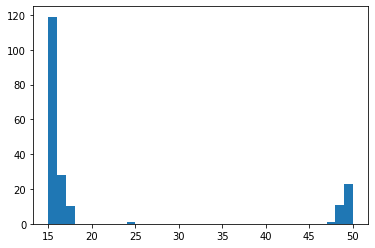

In [52]:
plt.hist(long_runs[2], bins=range(15,51))

(array([109.,  28.,   4.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.]),
 array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
        32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
        49, 50]),
 <BarContainer object of 35 artists>)

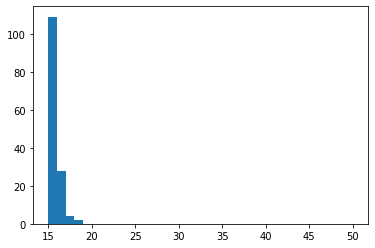

In [53]:
plt.hist(long_runs_random[2], bins=range(15,51))

(array([131.,  43.,   5.,   5.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.]),
 array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
        32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
        49, 50]),
 <BarContainer object of 35 artists>)

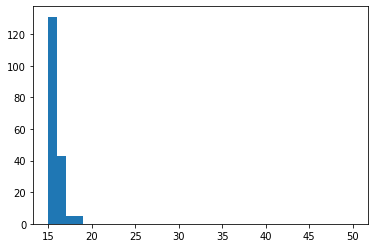

In [54]:
plt.hist(long_runs_train_shift[2], bins=range(15,51))

In [56]:
pickle.dump(long_runs, open("long_runs.pkl", "wb"))
pickle.dump(long_runs_random, open("long_runs_random.pkl", "wb"))
pickle.dump(long_runs_train_shift, open("long_runs_train_shift.pkl", "wb"))

In [ ]:
## check for correlation between read number and GC content ##